In [1]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyranges as pr
import glob as glob
import os
from importlib import reload
%matplotlib inline
import sys
sys.path.append("modules")
import bedgraph_tools as bgt
import peak_tools as pkt
from collections import defaultdict
import pyBigWig as pw
from matplotlib_venn import venn2
import pysam
from itertools import groupby
from Bio import motifs
import logomaker
from Bio import Align
from Bio.Seq import Seq
%config InlineBackend.figure_format='retina'
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
from scipy import stats
from scipy.interpolate import interp1d
import matplotlib.colors as mcolors
import upsetplot
from scipy.ndimage import uniform_filter


In [2]:
metadata = pd.read_parquet('sample_metadata_20250211.parquet')

In [3]:
gr = metadata.filter(regex='wt|lig', axis=0).filter(regex='nmumg', axis=0).filter(regex='gr', axis=0)
peak = gr.iloc[-1,-1]
peak = pr.read_bed(peak).df

/home/labs/barkailab/vovam/.local/lib/python3.10/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}


In [4]:
for cbw in np.concatenate(gr.loc[:, ['BigWig']].values.T[0]):
    bwi = pw.open(cbw)
    a = []
    for i in peak.loc[:, ['Chromosome', 'Start', 'End']].values:
        a.append(bwi.values(i[0], i[1], i[2], numpy=True).sum())
    peak.loc[:, cbw.split('/')[-1].split('_S')[0]] = a

In [5]:
peak.loc[:, 'Width'] = peak.End - peak.Start

Text(0, 0.5, 'Signal')

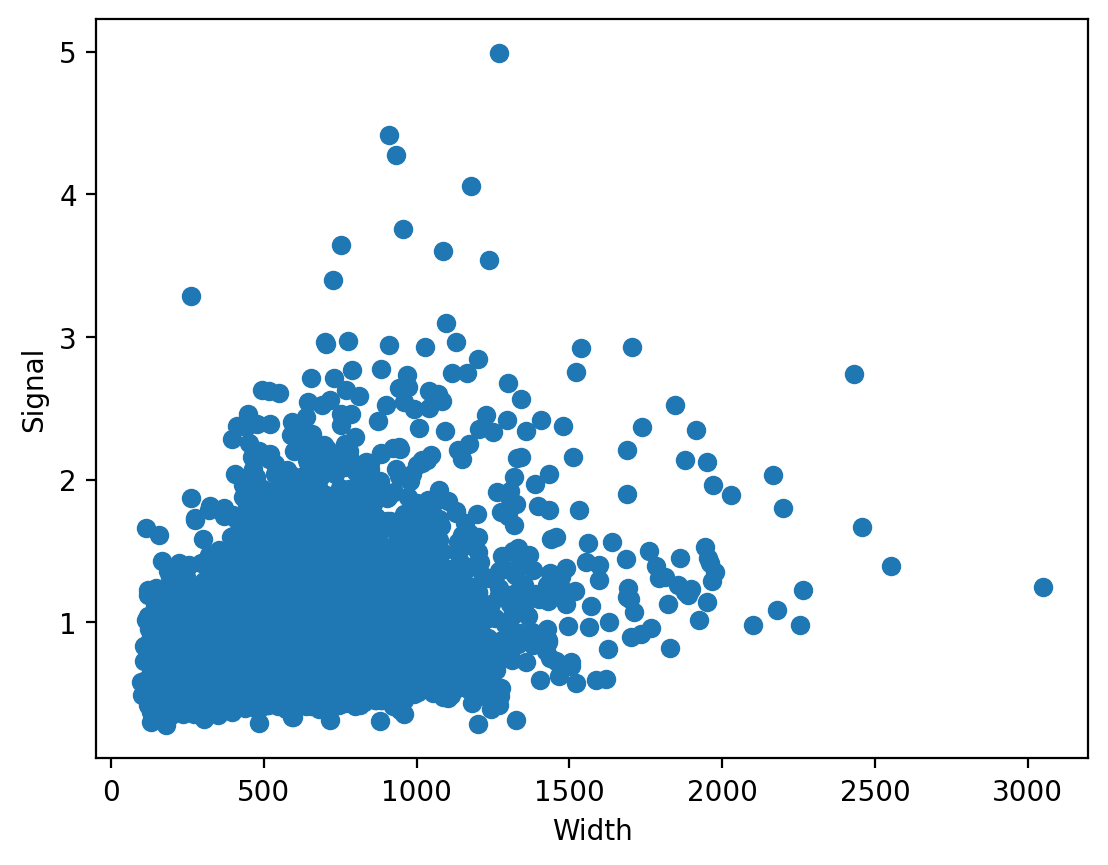

In [6]:
fig, ax = plt.subplots(1)
ax.scatter(peak.Width, peak.filter(regex='lig').mean(axis=1)/peak.Width, )
ax.set_xlabel('Width')
ax.set_ylabel('Signal')
# ax.set_yscale('log')
# ax.set_xscale('log')

In [7]:
os.makedirs('figures/Fig1', exist_ok=True)

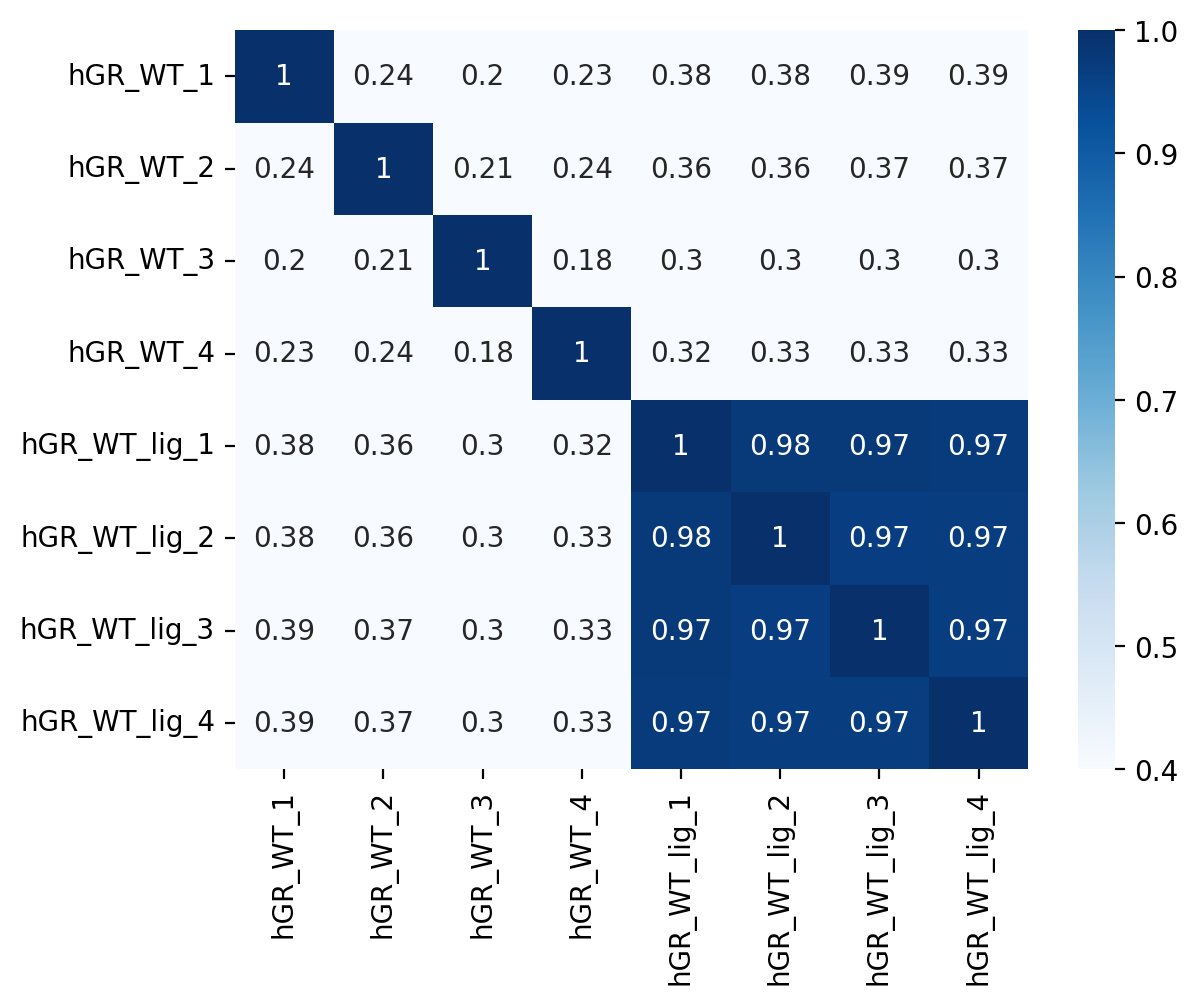

In [8]:
fig, ax = plt.subplots(1)
sns.heatmap(peak.filter(regex='GR').corr(), cmap='Blues', ax=ax, annot=True, vmin=.4)
fig.savefig('figures/Fig1/nmumg_gr_wtlig_corr.pdf')

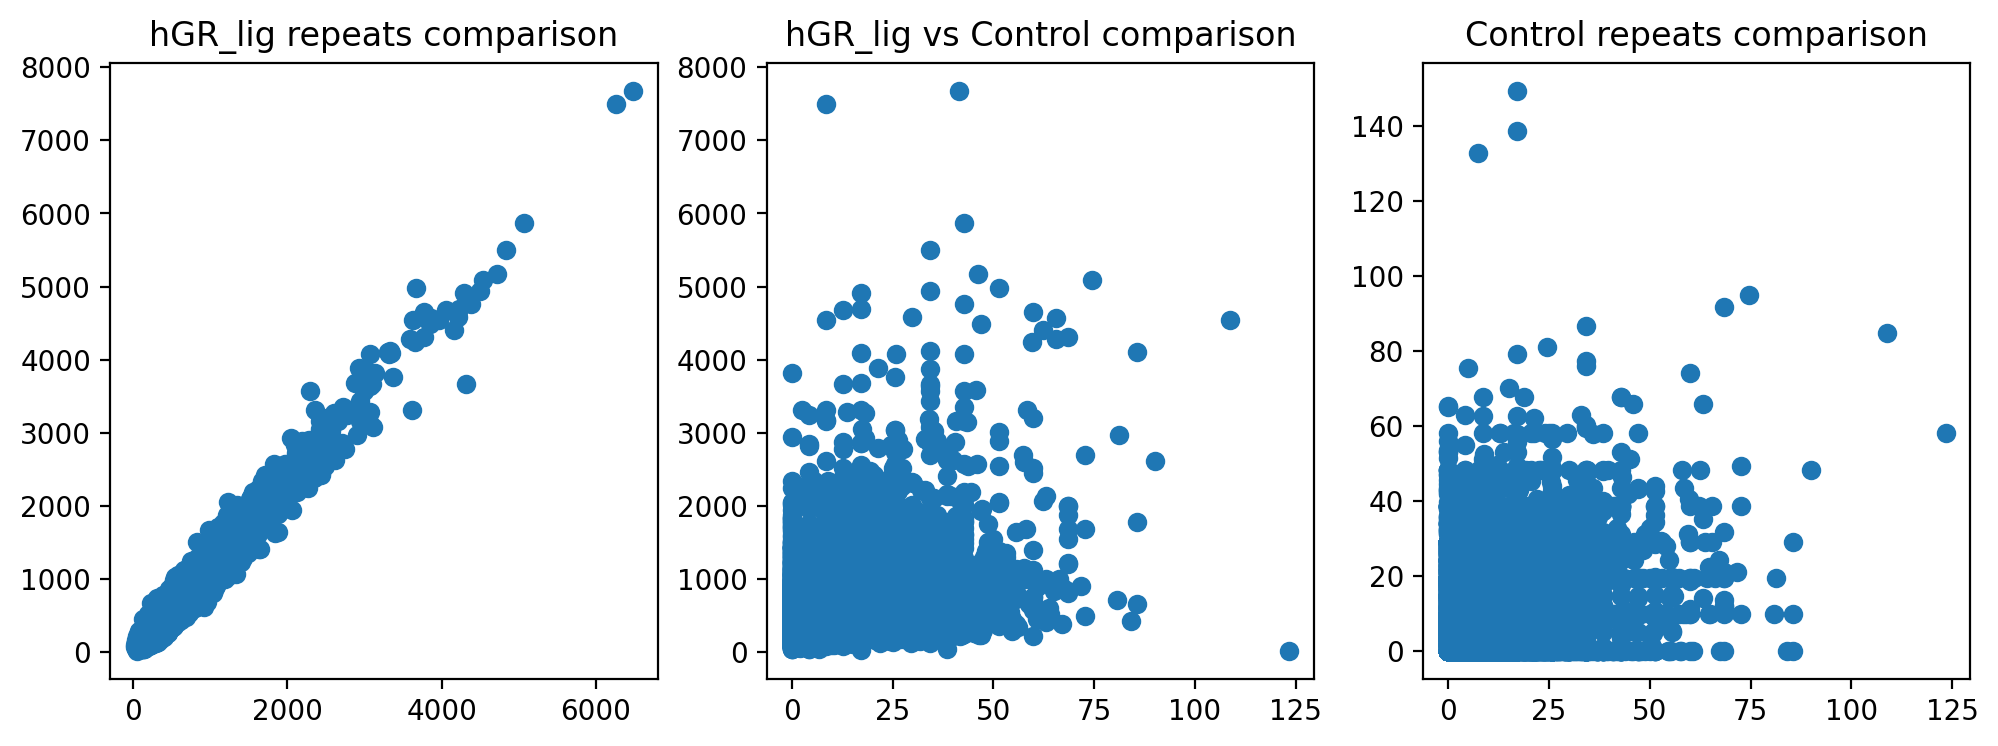

In [9]:
fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].scatter(peak.hGR_WT_lig_2, peak.hGR_WT_lig_1)
ax[1].scatter(peak.hGR_WT_1, peak.hGR_WT_lig_1)
ax[2].scatter(peak.hGR_WT_1, peak.hGR_WT_2)


ax[0].set_title('hGR_lig repeats comparison')
ax[1].set_title('hGR_lig vs Control comparison')
ax[2].set_title('Control repeats comparison')

fig.savefig('figures/Fig1/gr_wt_control_scatters.pdf')

In [10]:
aligner = Align.PairwiseAligner()


In [11]:
def load_and_add_name_col(path, name):
    pp = pr.read_bed(path)
    pp = pp.insert(pd.Series(data = np.char.add(np.arange(len(pp)).astype(str), '_{}'.format(name)), name="Column"))
    return pp
def load_mot(path, mot_path):
    with open(mot_path) as handle:
        cosensus_mot = motifs.read(handle, "pfm-four-columns").consensus

        # Extract the motif sequences (not specifically used below)
    loaded_loc = pd.read_csv(os.path.join(path, 'fimo.tsv'), delimiter='\t').iloc[:-3,: ]#.loc[:, ['motif_id', 'sequence_name', 'start', 'stop', 'strand', 'matched_sequence']]
    seqs = loaded_loc.sort_values(by='score', ascending=False).loc[:, 'matched_sequence']
#     loaded_loc['strand'] = seqs.apply(lambda x: align_mots(cosensus_mot, x, aligner)).values
    return loaded_loc
def align_mots(ref, seq2, aligner=aligner):
    aligned_F = aligner.align(ref, seq2)
    aligned_R = aligner.align(ref, Seq(seq2).reverse_complement())
    
    if aligned_F.score >= aligned_R.score:
        return "+"
    else:
        return "-"
    
def filter_top_quantile(group, quantile=0.9):
    """
    Filters rows in a group where the sum across columns is above the quantile threshold.
    
    Parameters:
        group (pd.DataFrame): Grouped DataFrame.
        quantile (float): The quantile threshold (default 0.9).
        
    Returns:
        pd.DataFrame: Filtered DataFrame with top quantile rows.
    """
    # Compute the sum across all numeric columns per row
    # row_sums = group.loc[:, list(np.arange(75,95).astype(str)) + list(np.arange(105,125).astype(str))].sum(axis=1)
    row_sums = group.loc[:, list(np.arange(200).astype(str))].sum(axis=1)

    # Compute the quantile threshold
    threshold = np.quantile(row_sums, quantile)

    # Return rows that exceed the threshold
    return group[row_sums >= threshold]

def compute_footprint_lengths(x, y, thresholds):
    """
    Compute footprint lengths for multiple percentage thresholds.
    
    Parameters:
        x (array-like): X-values (time or index)
        y (array-like): Y-values (signal intensity)
        thresholds (list): List of percentage drop values (e.g., [0.05, 0.1, 0.5])

    Returns:
        footprint_lengths (dict): Dictionary with thresholds as keys and footprint lengths as values.
    """
    # Interpolation function
    interp_func = interp1d(x, y, kind='linear')

    # Generate more dense x values for interpolation
    window = 600
    x_dense = np.linspace(min(x), max(x), window)
    y_dense = interp_func(x_dense)  # Interpolated y values

    # Find Peak
    peak_index = int(window/2)
    peak_x = x_dense[peak_index]
    peak_y = y_dense[peak_index]

    footprint_lengths = {}

    for threshold in thresholds:
        threshold_value = threshold * peak_y  # Compute threshold level

        # Find left and right drop-off points safely
        left_indices = np.where(y_dense[:peak_index] <= threshold_value)[0]
        right_indices = np.where(y_dense[peak_index:] <= threshold_value)[0]

        left_x = x_dense[left_indices[-1]] if len(left_indices) > 0 else None
        right_x = x_dense[right_indices[0] + peak_index] if len(right_indices) > 0 else None

        # Compute footprint length if both sides exist
        footprint_length = right_x - left_x if left_x is not None and right_x is not None else None

        footprint_lengths[threshold] = footprint_length

    return footprint_lengths

In [12]:
nmumg_peaks = metadata.filter(regex='lig|bmp', axis=0).filter(regex='nmumg', axis=0).loc[:, 'peaks_w_summits'].values
nmumg_peaks
conc_peaks = pr.concat([load_and_add_name_col(x, x.split('/')[-1].split('_fc10')[0]) for x in nmumg_peaks])
cluster_peaks = conc_peaks.cluster(slack=100)
groupd_clustered = cluster_peaks.df.groupby("Cluster").agg(lambda x: list(x))
needed_columns = groupd_clustered.loc[:, ['Chromosome', 'Start', 'End', 'Column']]
needed_columns.loc[:, 'Chromosome'] = needed_columns.Chromosome.apply(lambda x: x[0])
needed_columns.loc[:, 'Start'] = needed_columns.Start.apply(lambda x: np.ceil(np.mean(x))).astype(int)
needed_columns.loc[:, 'End'] = needed_columns.End.apply(lambda x: np.ceil(np.mean(x))).astype(int)
needed_columns.iloc[:, [0,1,2]].to_csv('cell_peaks_dbddlbdwtlig/nmumg_clustered_peak_wt_ligand_samples.bed'
                                       ,index=False, header=False, sep='\t')

# bedtools getfasta -bed nmumg_clustered_peak_wt_ligand_samples.bed -fo nmumg_clustered_peak_wt_ligand_samples.bed.fasta -fi /shareDB/iGenomes/Mus_musculus/UCSC/mm10/Sequence/WholeGenomeFasta/genome.fa
# fimo --oc mot_enrich/FOX_nmumg_wt_lig_cluster_parsed --parse-genomic-coord --motif GR_FOX ../nmumg_nr_ap1_ligmots_20250211.meme nmumg_clustered_peak_wt_ligand_samples.bed.fasta
# fimo --oc mot_enrich/AP1_nmumg_wt_lig_cluster_parsed --parse-genomic-coord --motif GR_AP1 ../nmumg_nr_ap1_ligmots_20250211.meme nmumg_clustered_peak_wt_ligand_samples.bed.fasta
# fimo --oc mot_enrich/NR_nmumg_wt_lig_cluster_parsed --parse-genomic-coord --motif GR_NR ../nmumg_nr_ap1_ligmots_20250211.meme nmumg_clustered_peak_wt_ligand_samples.bed.fasta
# fimo --oc mot_enrich/NR_hs_nmumg_wt_lig_cluster_parsed --parse-genomic-coord --motif GR_halfsite ../nmumg_nr_ap1_ligmots_20250211.meme nmumg_clustered_peak_wt_ligand_samples.bed.fasta
# fimo --oc mot_enrich/SMAD2_nmumg_wt_lig_cluster_parsed --parse-genomic-coord --motif SMAD1_SMAD2 ../nmumg_nr_ap1_ligmots_20250211.meme nmumg_clustered_peak_wt_ligand_samples.bed.fasta


mot_folders = ['cell_peaks_dbddlbdwtlig/mot_enrich/NR_hs_nmumg_wt_lig_cluster_parsed/', 
'cell_peaks_dbddlbdwtlig/mot_enrich/NR_nmumg_wt_lig_cluster_parsed/',
'cell_peaks_dbddlbdwtlig/mot_enrich/AP1_nmumg_wt_lig_cluster_parsed/', 
'cell_peaks_dbddlbdwtlig/mot_enrich/FOX_nmumg_wt_lig_cluster_parsed', 
  'cell_peaks_dbddlbdwtlig/mot_enrich/SMAD2_nmumg_wt_lig_cluster_parsed/',
               'cell_peaks_dbddlbdwtlig/mot_enrich/TEAD_nmumg_wt_lig_cluster_parsed/',
               'cell_peaks_dbddlbdwtlig/mot_enrich/KLF_nmumg_wt_lig_cluster_parsed/',
               'cell_peaks_dbddlbdwtlig/mot_enrich/RUNX_nmumg_wt_lig_cluster_parsed/',
               'cell_peaks_dbddlbdwtlig/mot_enrich/CTCF_nmumg_wt_lig_cluster_parsed/'
               
              ]

motd = { 'GR_halfsite':'combined_threshed_peaks_wsummits/output_homer_nmumg_hgr_dbd_fc10.bed/homerResults/motif4.motif',
        'GR_NR' : 'combined_threshed_peaks_wsummits/output_homer_nmumg_hgr_wt_lig_fc10.bed/homerResults/motif3.motif',
        'GR_AP1': 'combined_threshed_peaks_wsummits/output_homer_nmumg_hgr_wt_lig_fc10.bed/homerResults/motif1.motif',
        'GR_FOX' : 'combined_threshed_peaks_wsummits/output_homer_nmumg_hgr_wt_lig_fc10.bed/homerResults/motif5.motif', 
     'SMAD1_SMAD2':'combined_threshed_peaks_wsummits/output_homer_nmumg_smad1_bmp_high_fc10.bed/homerResults/motif2.motif',
        'GR_TEAD':'combined_threshed_peaks_wsummits/output_homer_nmumg_hgr_wt_lig_fc10.bed/homerResults/motif4.motif',
      'GR_KLF':'combined_threshed_peaks_wsummits/output_homer_nmumg_hgr_wt_lig_fc10.bed/homerResults/motif2.motif',
    'GR_RUNX':'combined_threshed_peaks_wsummits/output_homer_nmumg_hgr_wt_lig_fc10.bed/homerResults/motif6.motif',
              'GR_CTCF':'combined_threshed_peaks_wsummits/output_homer_nmumg_hgr_dbd_fc10.bed/homerResults/motif2.motif',

    }
name_path_mot = dict(zip(mot_folders, motd.values()))

all_motifs = pd.concat([load_mot(x, name_path_mot[x]) for x in mot_folders])
all_motifs.loc[:, 'middle'] = np.ceil(((all_motifs.stop - all_motifs.start)/2) + all_motifs.start).astype(np.int32)
all_motifs = all_motifs.loc[:, ['motif_id', 'sequence_name', 'start', 'stop', 'strand', 'middle']]
all_motifs.columns = ['id', 'Chromosome', 'Start', 'End', 'Strand', 'Middle']
remove_clusters = pr.PyRanges(all_motifs).cluster(slack=20).df.groupby('Cluster').count().query("id > 1").index
all_motifs = pr.PyRanges(all_motifs).cluster(slack=20).df.set_index("Cluster").drop(remove_clusters)
all_motifs.to_csv('cell_peaks_dbddlbdwtlig/nmumg_wt_ligand_motifs_location_in_peaks.csv')

bgs = metadata.filter(regex='lig|bmp', axis=0).filter(regex='nmumg', axis=0).loc[:, ['NormBG']].T.to_dict()


procf_barebones = 'bsub -n 8 -q short -R \"span[hosts=1]\" -R \"rusage[mem=4000]\" \"python mot_analysis.py --bedgraph {blist} --motifs cell_peaks_dbddlbdwtlig/nmumg_wt_ligand_motifs_location_in_peaks.csv --output {out}\"'

for key, value in bgs.items():
    out = "cell_peaks_dbddlbdwtlig/wt_ligand_{}".format(key)
    print(procf_barebones.format(blist=' '.join(value['NormBG']), out=out))

/home/labs/barkailab/vovam/.local/lib/python3.10/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}
/home/labs/barkailab/vovam/.local/lib/python3.10/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}
/home/labs/barkailab/vovam/.local/lib/python3.10/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain curr

bsub -n 8 -q short -R "span[hosts=1]" -R "rusage[mem=4000]" "python mot_analysis.py --bedgraph /home/labs/barkailab/vovam/../LAB/data/SEQ/AchInbal_Data/NMuMG_all/results/bedgraphs/hGR_WT_lig_1_S26.bedgraph.gz /home/labs/barkailab/vovam/../LAB/data/SEQ/AchInbal_Data/NMuMG_all/results/bedgraphs/hGR_WT_lig_2_S27.bedgraph.gz /home/labs/barkailab/vovam/../LAB/data/SEQ/AchInbal_Data/NMuMG_all/results/bedgraphs/hGR_WT_lig_3_S64.bedgraph.gz /home/labs/barkailab/vovam/../LAB/data/SEQ/AchInbal_Data/NMuMG_all/results/bedgraphs/hGR_WT_lig_4_S28.bedgraph.gz --motifs cell_peaks_dbddlbdwtlig/nmumg_wt_ligand_motifs_location_in_peaks.csv --output cell_peaks_dbddlbdwtlig/wt_ligand_nmumg_hgr_wt_lig"
bsub -n 8 -q short -R "span[hosts=1]" -R "rusage[mem=4000]" "python mot_analysis.py --bedgraph /home/labs/barkailab/vovam/../LAB/data/SEQ/AchInbal_Data/NMuMG_all/results/bedgraphs/hPR_WT_lig_1_S26.bedgraph.gz /home/labs/barkailab/vovam/../LAB/data/SEQ/AchInbal_Data/NMuMG_all/results/bedgraphs/hPR_WT_lig_2_S27

In [13]:
nmumg_peaks

array(['/home/labs/barkailab/vovam/Mammalian/Mammal_AchInbalOvaJd/combined_threshed_peaks_wsummits/nmumg_hgr_wt_lig_fc10.bed',
       '/home/labs/barkailab/vovam/Mammalian/Mammal_AchInbalOvaJd/combined_threshed_peaks_wsummits/nmumg_hpr_wt_lig_fc10.bed',
       '/home/labs/barkailab/vovam/Mammalian/Mammal_AchInbalOvaJd/combined_threshed_peaks_wsummits/nmumg_mar_wt_lig_fc10.bed',
       '/home/labs/barkailab/vovam/Mammalian/Mammal_AchInbalOvaJd/combined_threshed_peaks_wsummits/nmumg_smad1_bmp_high_fc10.bed'],
      dtype=object)

In [14]:
peak_len_func = lambda x: pl.read_csv(x, has_header=False, separator='\t').with_columns((pl.col('column_3') - pl.col('column_2')).alias('Width')).select('Width').to_numpy().T.squeeze()

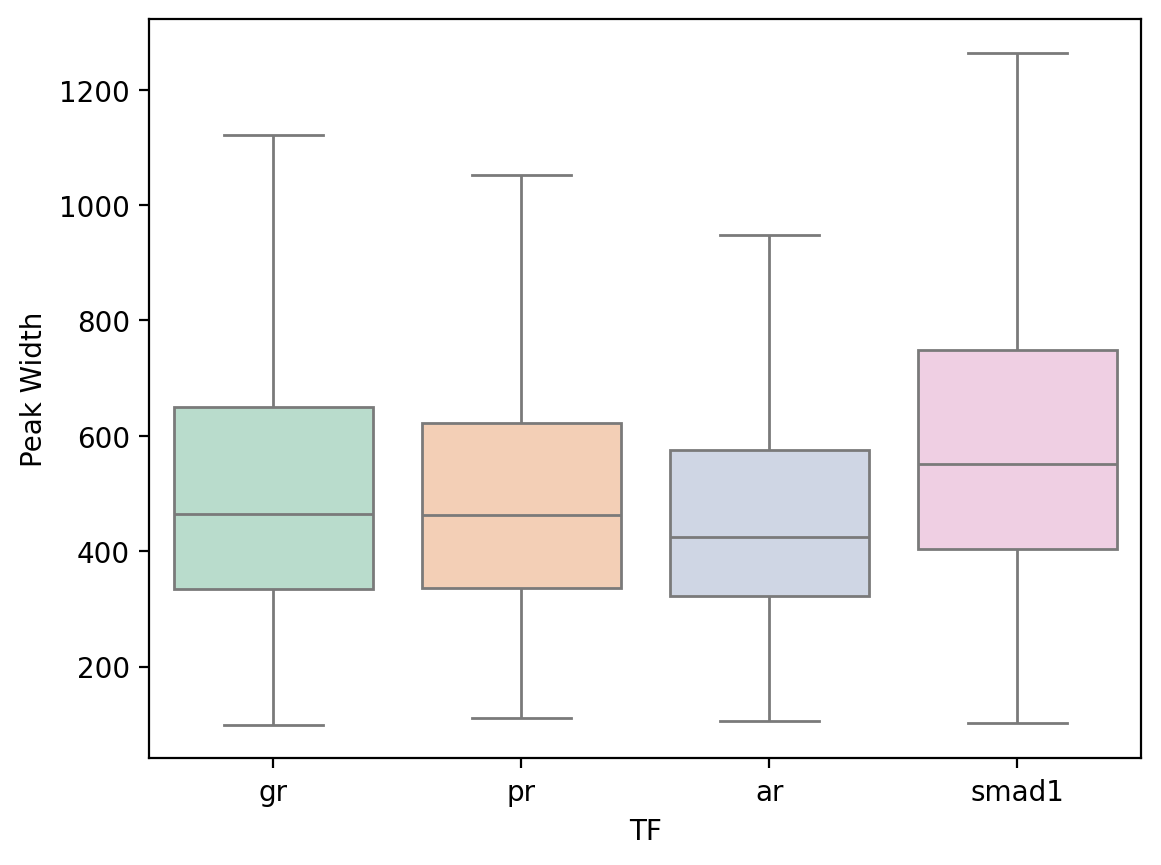

In [15]:
fig, ax = plt.subplots(1)
sns.boxplot(dict(zip(['gr', 'pr', 'ar', 'smad1'], map(peak_len_func, nmumg_peaks))), showfliers=False, palette='Pastel2', ax=ax)
ax.set_xlabel('TF')
ax.set_ylabel("Peak Width")
fig.savefig('figures/Supp/peak_width.pdf')

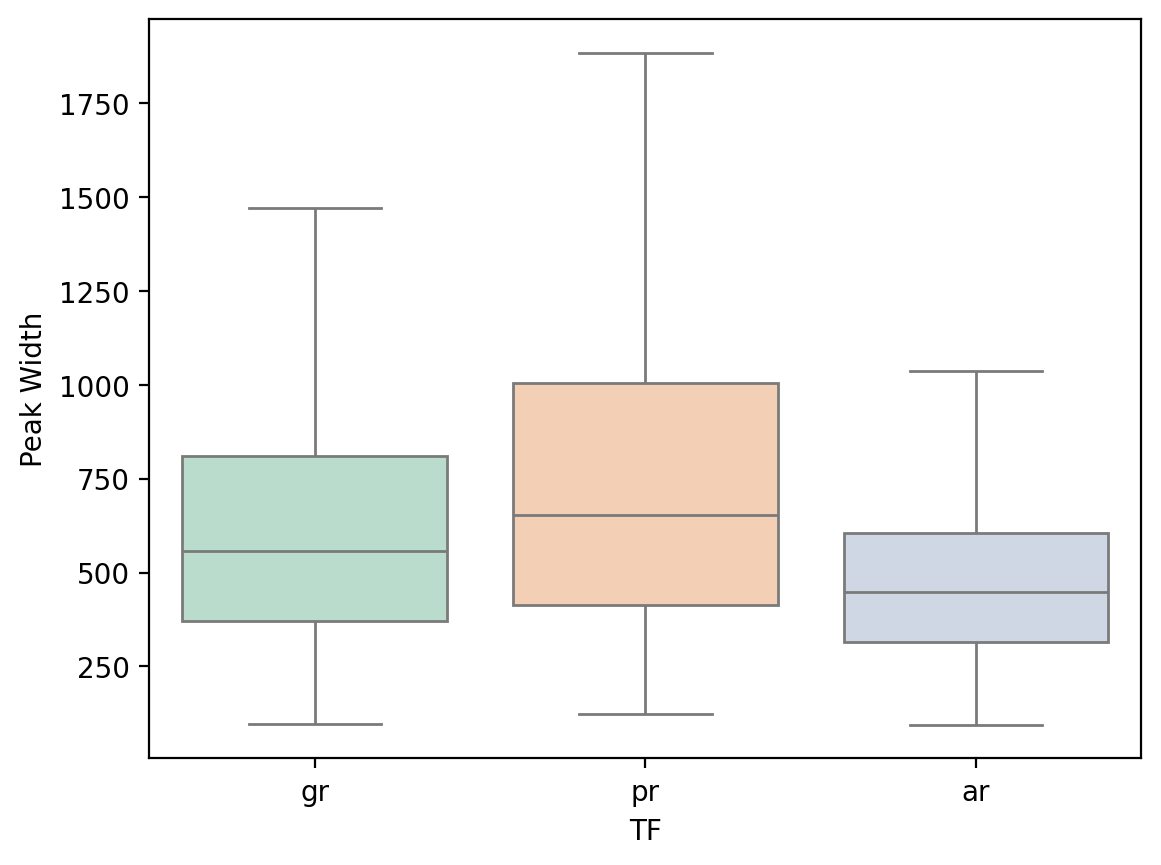

In [16]:

dbd_peaks = metadata.filter(regex='dbd', axis=0).filter(regex='nmumg', axis=0).loc[:, 'peaks_w_summits'].values


fig, ax = plt.subplots(1)
sns.boxplot(dict(zip(['gr', 'pr', 'ar', 'smad1'], map(peak_len_func, dbd_peaks))), showfliers=False, palette='Pastel2', ax=ax)
ax.set_xlabel('TF')
ax.set_ylabel("Peak Width")
fig.savefig('figures/Supp/peak_width_dbds.pdf')

In [17]:
mot_signals = sorted(glob.glob('cell_peaks_dbddlbdwtlig/wt_ligand_nmumg*'))


In [18]:
forhtmp = dict()
alldf = pd.DataFrame()
allfoot_df = pd.DataFrame()
for sig in mot_signals:
    a = pd.read_parquet(sig)
    # analyzed = a.loc[:, ['id'] + list(np.arange(200).astype(str))].groupby('id', group_keys=False).apply(filter_top_quantile, 0.9).groupby('id').mean().T
    analyzed = a.loc[:, ['id'] + list(np.arange(200).astype(str))]
    foot_df = pd.DataFrame()
    for idi in analyzed.id.unique():
        proc_df = filter_top_quantile(analyzed[analyzed.id == idi].loc[:, np.arange(200).astype(str)], 0.9)
        forhtmp[idi+sig.split('/')[-1].split('__signals')[0].replace('nmumg_', '')] = proc_df
        top5_cols = (
                proc_df.iloc[:, :200]
                .mean()
                .sort_values(ascending=False)
                .iloc[:5]
                .index
                .astype(int)
            )
        null = proc_df.iloc[:, top5_cols].values.flatten()
        func = lambda x: stats.mannwhitneyu(null, x)[1]
        calc_pvs = proc_df.iloc[:, :200].apply(func, axis=0)
        calc_pvs[(calc_pvs == 0)] = calc_pvs[~(calc_pvs == 0)].min()
        m10log10pval = (-10 * np.log10(calc_pvs))
        
        foot  = pd.DataFrame(compute_footprint_lengths(m10log10pval.index.astype(int), m10log10pval, np.arange(0.05,1.05,0.05)), index=[idi]).T
        foot_df = pd.concat([foot_df, foot], axis=1)
    analyzed = analyzed.groupby('id', group_keys=False).apply(filter_top_quantile, 0.9).groupby('id').mean().T
    analyzed.columns = [x+ '_' + sig.split('/')[-1].split('__signals')[0].replace('nmumg_', '') for x in analyzed.columns]
    foot_df.columns = [x+ '_' + sig.split('/')[-1].split('__signals')[0].replace('nmumg_', '') for x in foot_df.columns]

    alldf = pd.concat([alldf, analyzed], axis=1)
    allfoot_df = pd.concat([allfoot_df, foot_df], axis=1)

/tmp/ipykernel_2296472/1382638561.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  analyzed = analyzed.groupby('id', group_keys=False).apply(filter_top_quantile, 0.9).groupby('id').mean().T
/tmp/ipykernel_2296472/1382638561.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  analyzed = analyzed.groupby('id', group_keys=False).apply(filter_top_quantile, 0.9).groupby('id').mean().T
/tmp/ipykernel_2296472

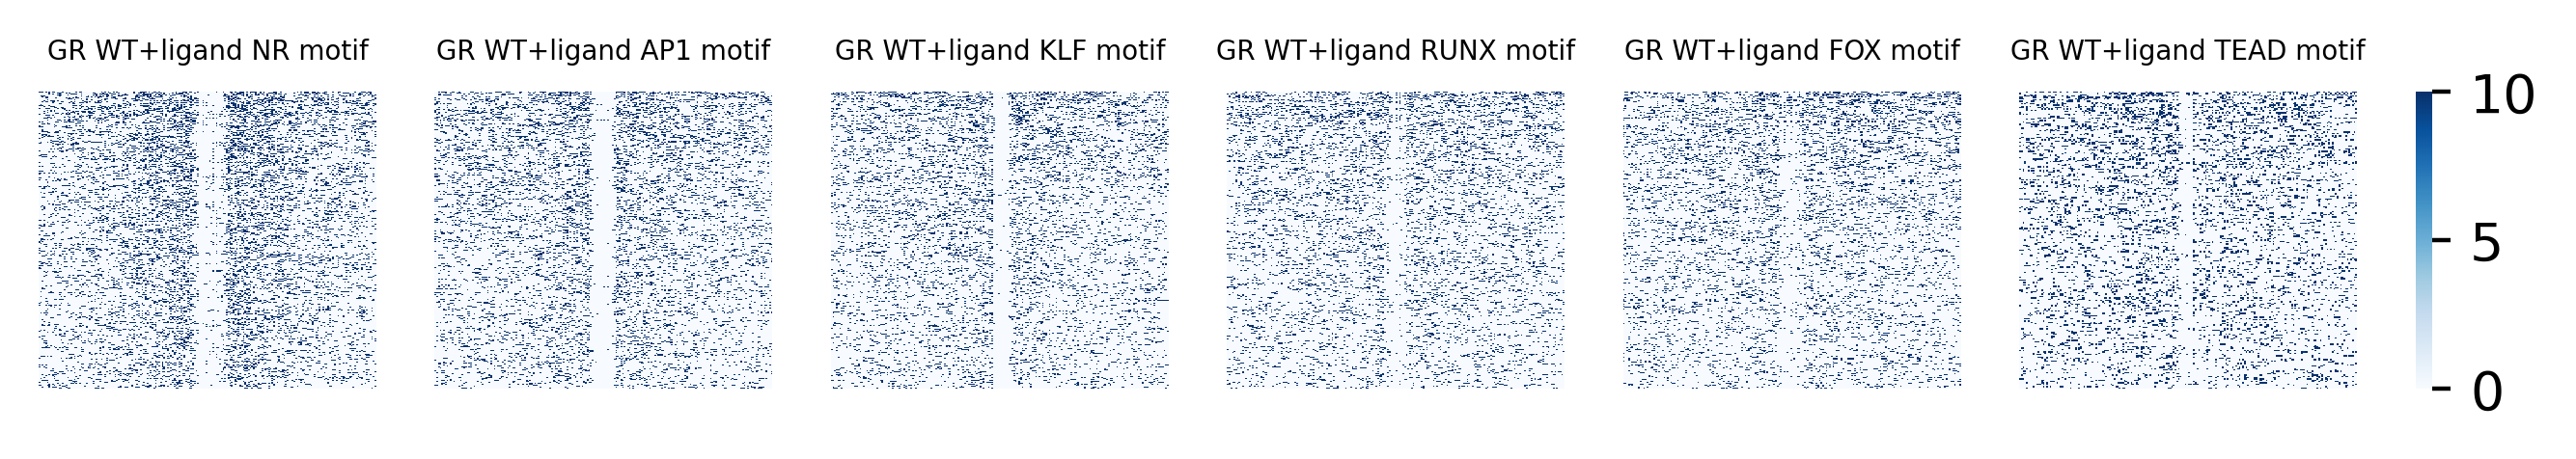

In [19]:
fig, ax = plt.subplots(1,7, width_ratios=[5,5,5,5,5,5,.25], figsize=(8,1), dpi=200)

indices = forhtmp['GR_NRwt_ligand_hgr_wt_lig_signals_on_motifs.parquet'].sum(axis=1).sort_values(ascending=False).index
sns.heatmap(forhtmp['GR_NRwt_ligand_hgr_wt_lig_signals_on_motifs.parquet'].loc[indices],
            cmap='Blues', vmin=0, vmax=10, ax=ax[0], yticklabels=False, xticklabels=False, cbar_ax = ax[-1], rasterized=True)

indices = forhtmp['GR_AP1wt_ligand_hgr_wt_lig_signals_on_motifs.parquet'].sum(axis=1).sort_values(ascending=False).index
sns.heatmap(forhtmp['GR_AP1wt_ligand_hgr_wt_lig_signals_on_motifs.parquet'].loc[indices],
            cmap='Blues', vmin=0, vmax=10, ax=ax[1], yticklabels=False, xticklabels=False, cbar=False, rasterized=True)

indices = forhtmp['GR_KLFwt_ligand_hgr_wt_lig_signals_on_motifs.parquet'].sum(axis=1).sort_values(ascending=False).index
sns.heatmap(forhtmp['GR_KLFwt_ligand_hgr_wt_lig_signals_on_motifs.parquet'].loc[indices],
            cmap='Blues', vmin=0, vmax=10, ax=ax[2], yticklabels=False, xticklabels=False, cbar=False, rasterized=True)

indices = forhtmp['GR_RUNXwt_ligand_hgr_wt_lig_signals_on_motifs.parquet'].sum(axis=1).sort_values(ascending=False).index
sns.heatmap(forhtmp['GR_RUNXwt_ligand_hgr_wt_lig_signals_on_motifs.parquet'].loc[indices],
            cmap='Blues', vmin=0, vmax=10, ax=ax[3], yticklabels=False, xticklabels=False, cbar=False, rasterized=True)

indices = forhtmp['GR_FOXwt_ligand_hgr_wt_lig_signals_on_motifs.parquet'].sum(axis=1).sort_values(ascending=False).index
sns.heatmap(forhtmp['GR_FOXwt_ligand_hgr_wt_lig_signals_on_motifs.parquet'].loc[indices],
            cmap='Blues', vmin=0, vmax=10, ax=ax[4], yticklabels=False, xticklabels=False, cbar=False, rasterized=True)

indices = forhtmp['GR_TEADwt_ligand_hgr_wt_lig_signals_on_motifs.parquet'].sum(axis=1).sort_values(ascending=False).index
sns.heatmap(forhtmp['GR_TEADwt_ligand_hgr_wt_lig_signals_on_motifs.parquet'].loc[indices],
            cmap='Blues', vmin=0, vmax=10, ax=ax[5], yticklabels=False, xticklabels=False, cbar=False, rasterized=True)

ax[0].set_title("GR WT+ligand NR motif", size=5)
ax[1].set_title("GR WT+ligand AP1 motif", size=5)
ax[2].set_title("GR WT+ligand KLF motif", size=5)
ax[3].set_title("GR WT+ligand RUNX motif", size=5)
ax[4].set_title("GR WT+ligand FOX motif", size=5)
ax[5].set_title("GR WT+ligand TEAD motif", size=5)

fig.savefig('figures/Fig1/gr_lig_fotprnt_htmp.pdf')

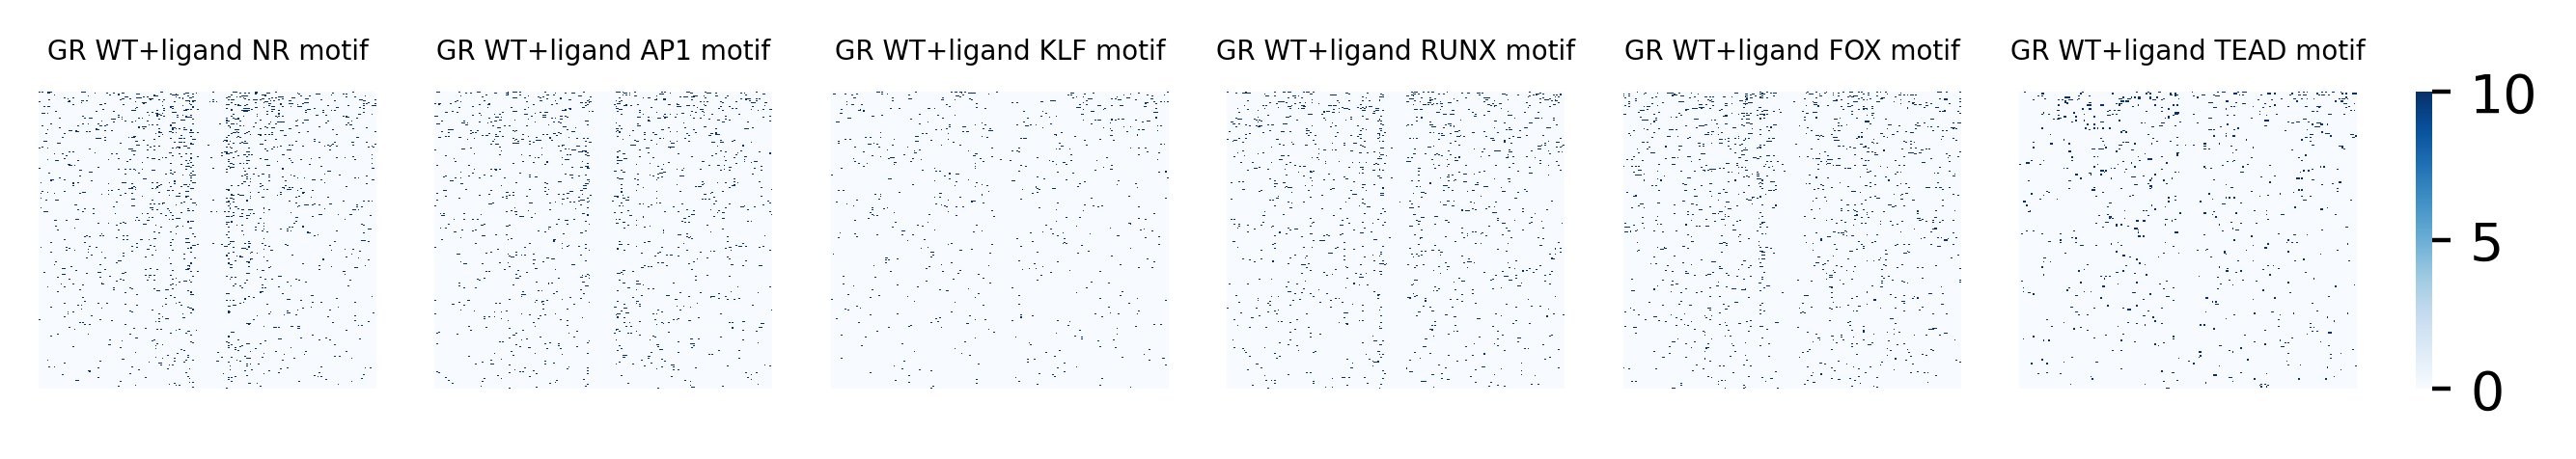

In [20]:
fig, ax = plt.subplots(1,7, width_ratios=[5,5,5,5,5,5,.25], figsize=(8,1), dpi=200)

indices = forhtmp['GR_NRwt_ligand_mar_wt_lig_signals_on_motifs.parquet'].sum(axis=1).sort_values(ascending=False).index
sns.heatmap(forhtmp['GR_NRwt_ligand_mar_wt_lig_signals_on_motifs.parquet'].loc[indices],
            cmap='Blues', vmin=0, vmax=10, ax=ax[0], yticklabels=False, xticklabels=False, cbar_ax = ax[-1], rasterized=True)

indices = forhtmp['GR_AP1wt_ligand_mar_wt_lig_signals_on_motifs.parquet'].sum(axis=1).sort_values(ascending=False).index
sns.heatmap(forhtmp['GR_AP1wt_ligand_mar_wt_lig_signals_on_motifs.parquet'].loc[indices],
            cmap='Blues', vmin=0, vmax=10, ax=ax[1], yticklabels=False, xticklabels=False, cbar=False, rasterized=True)

indices = forhtmp['GR_KLFwt_ligand_mar_wt_lig_signals_on_motifs.parquet'].sum(axis=1).sort_values(ascending=False).index
sns.heatmap(forhtmp['GR_KLFwt_ligand_mar_wt_lig_signals_on_motifs.parquet'].loc[indices],
            cmap='Blues', vmin=0, vmax=10, ax=ax[2], yticklabels=False, xticklabels=False, cbar=False, rasterized=True)

indices = forhtmp['GR_RUNXwt_ligand_mar_wt_lig_signals_on_motifs.parquet'].sum(axis=1).sort_values(ascending=False).index
sns.heatmap(forhtmp['GR_RUNXwt_ligand_mar_wt_lig_signals_on_motifs.parquet'].loc[indices],
            cmap='Blues', vmin=0, vmax=10, ax=ax[3], yticklabels=False, xticklabels=False, cbar=False, rasterized=True)

indices = forhtmp['GR_FOXwt_ligand_mar_wt_lig_signals_on_motifs.parquet'].sum(axis=1).sort_values(ascending=False).index
sns.heatmap(forhtmp['GR_FOXwt_ligand_mar_wt_lig_signals_on_motifs.parquet'].loc[indices],
            cmap='Blues', vmin=0, vmax=10, ax=ax[4], yticklabels=False, xticklabels=False, cbar=False, rasterized=True)

indices = forhtmp['GR_TEADwt_ligand_mar_wt_lig_signals_on_motifs.parquet'].sum(axis=1).sort_values(ascending=False).index
sns.heatmap(forhtmp['GR_TEADwt_ligand_mar_wt_lig_signals_on_motifs.parquet'].loc[indices],
            cmap='Blues', vmin=0, vmax=10, ax=ax[5], yticklabels=False, xticklabels=False, cbar=False, rasterized=True)

ax[0].set_title("GR WT+ligand NR motif", size=5)
ax[1].set_title("GR WT+ligand AP1 motif", size=5)
ax[2].set_title("GR WT+ligand KLF motif", size=5)
ax[3].set_title("GR WT+ligand RUNX motif", size=5)
ax[4].set_title("GR WT+ligand FOX motif", size=5)
ax[5].set_title("GR WT+ligand TEAD motif", size=5)

fig.savefig('figures/Fig1/ar_lig_fotprnt_htmp.pdf')

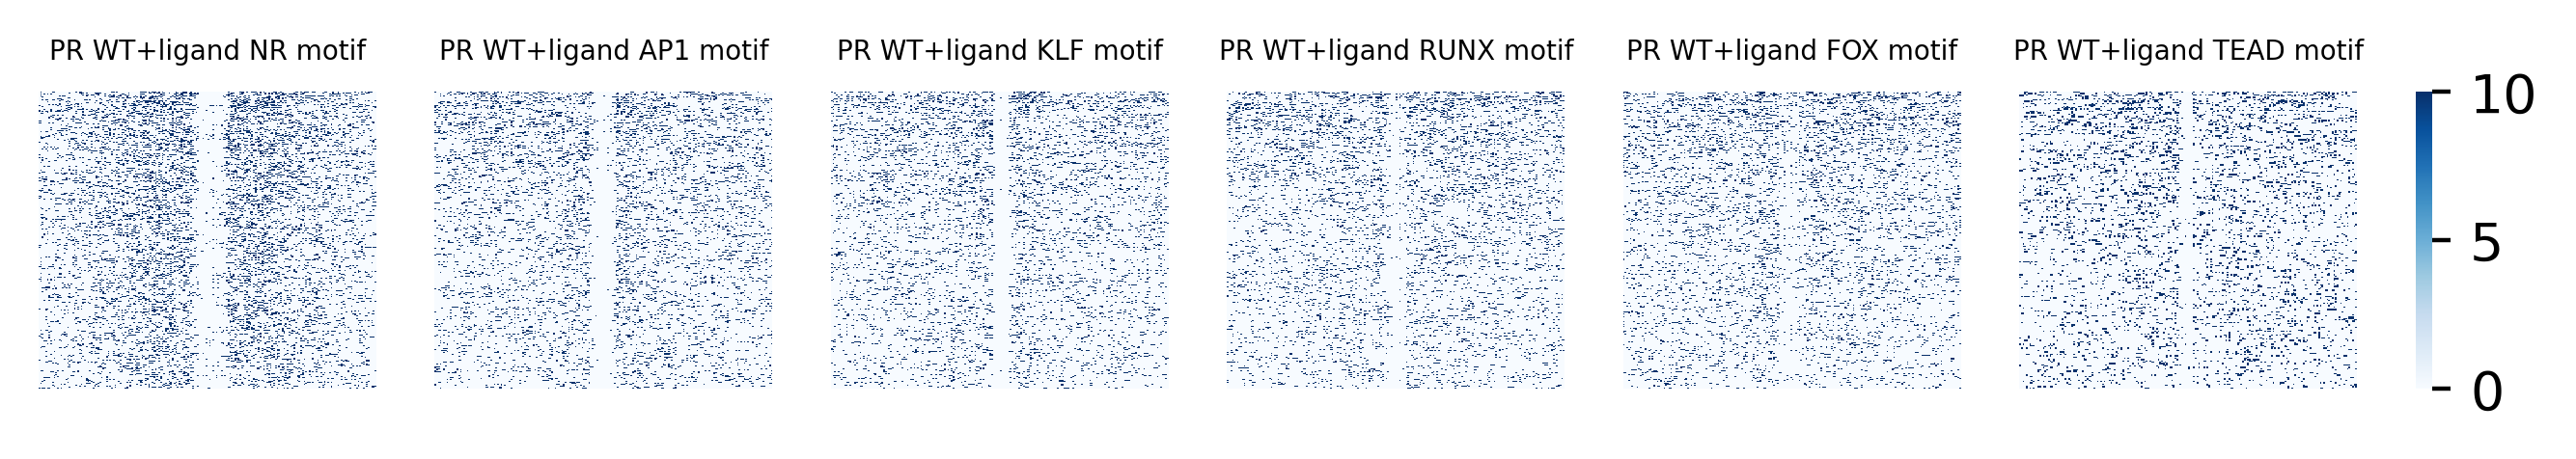

In [21]:
fig, ax = plt.subplots(1,7, width_ratios=[5,5,5,5,5,5,.25], figsize=(8,1), dpi=200)

indices = forhtmp['GR_NRwt_ligand_hpr_wt_lig_signals_on_motifs.parquet'].sum(axis=1).sort_values(ascending=False).index
sns.heatmap(forhtmp['GR_NRwt_ligand_hpr_wt_lig_signals_on_motifs.parquet'].loc[indices],
            cmap='Blues', vmin=0, vmax=10, ax=ax[0], yticklabels=False, xticklabels=False, cbar_ax = ax[-1], rasterized=True)

indices = forhtmp['GR_AP1wt_ligand_hpr_wt_lig_signals_on_motifs.parquet'].sum(axis=1).sort_values(ascending=False).index
sns.heatmap(forhtmp['GR_AP1wt_ligand_hpr_wt_lig_signals_on_motifs.parquet'].loc[indices],
            cmap='Blues', vmin=0, vmax=10, ax=ax[1], yticklabels=False, xticklabels=False, cbar=False, rasterized=True)

indices = forhtmp['GR_KLFwt_ligand_hpr_wt_lig_signals_on_motifs.parquet'].sum(axis=1).sort_values(ascending=False).index
sns.heatmap(forhtmp['GR_KLFwt_ligand_hpr_wt_lig_signals_on_motifs.parquet'].loc[indices],
            cmap='Blues', vmin=0, vmax=10, ax=ax[2], yticklabels=False, xticklabels=False, cbar=False, rasterized=True)

indices = forhtmp['GR_RUNXwt_ligand_hpr_wt_lig_signals_on_motifs.parquet'].sum(axis=1).sort_values(ascending=False).index
sns.heatmap(forhtmp['GR_RUNXwt_ligand_hpr_wt_lig_signals_on_motifs.parquet'].loc[indices],
            cmap='Blues', vmin=0, vmax=10, ax=ax[3], yticklabels=False, xticklabels=False, cbar=False, rasterized=True)

indices = forhtmp['GR_FOXwt_ligand_hpr_wt_lig_signals_on_motifs.parquet'].sum(axis=1).sort_values(ascending=False).index
sns.heatmap(forhtmp['GR_FOXwt_ligand_hpr_wt_lig_signals_on_motifs.parquet'].loc[indices],
            cmap='Blues', vmin=0, vmax=10, ax=ax[4], yticklabels=False, xticklabels=False, cbar=False, rasterized=True)

indices = forhtmp['GR_TEADwt_ligand_hpr_wt_lig_signals_on_motifs.parquet'].sum(axis=1).sort_values(ascending=False).index
sns.heatmap(forhtmp['GR_TEADwt_ligand_hpr_wt_lig_signals_on_motifs.parquet'].loc[indices],
            cmap='Blues', vmin=0, vmax=10, ax=ax[5], yticklabels=False, xticklabels=False, cbar=False, rasterized=True)

ax[0].set_title("PR WT+ligand NR motif", size=5)
ax[1].set_title("PR WT+ligand AP1 motif", size=5)
ax[2].set_title("PR WT+ligand KLF motif", size=5)
ax[3].set_title("PR WT+ligand RUNX motif", size=5)
ax[4].set_title("PR WT+ligand FOX motif", size=5)
ax[5].set_title("PR WT+ligand TEAD motif", size=5)

fig.savefig('figures/Fig1/pr_lig_fotprnt_htmp.pdf')

In [22]:
forhtmp.keys()

dict_keys(['GR_CTCFwt_ligand_hgr_wt_lig_signals_on_motifs.parquet', 'GR_AP1wt_ligand_hgr_wt_lig_signals_on_motifs.parquet', 'GR_NRwt_ligand_hgr_wt_lig_signals_on_motifs.parquet', 'GR_RUNXwt_ligand_hgr_wt_lig_signals_on_motifs.parquet', 'GR_FOXwt_ligand_hgr_wt_lig_signals_on_motifs.parquet', 'GR_halfsitewt_ligand_hgr_wt_lig_signals_on_motifs.parquet', 'GR_KLFwt_ligand_hgr_wt_lig_signals_on_motifs.parquet', 'GR_TEADwt_ligand_hgr_wt_lig_signals_on_motifs.parquet', 'SMAD1_SMAD2wt_ligand_hgr_wt_lig_signals_on_motifs.parquet', 'GR_CTCFwt_ligand_hpr_wt_lig_signals_on_motifs.parquet', 'GR_AP1wt_ligand_hpr_wt_lig_signals_on_motifs.parquet', 'GR_NRwt_ligand_hpr_wt_lig_signals_on_motifs.parquet', 'GR_RUNXwt_ligand_hpr_wt_lig_signals_on_motifs.parquet', 'GR_FOXwt_ligand_hpr_wt_lig_signals_on_motifs.parquet', 'GR_halfsitewt_ligand_hpr_wt_lig_signals_on_motifs.parquet', 'GR_KLFwt_ligand_hpr_wt_lig_signals_on_motifs.parquet', 'GR_TEADwt_ligand_hpr_wt_lig_signals_on_motifs.parquet', 'SMAD1_SMAD2wt_lig

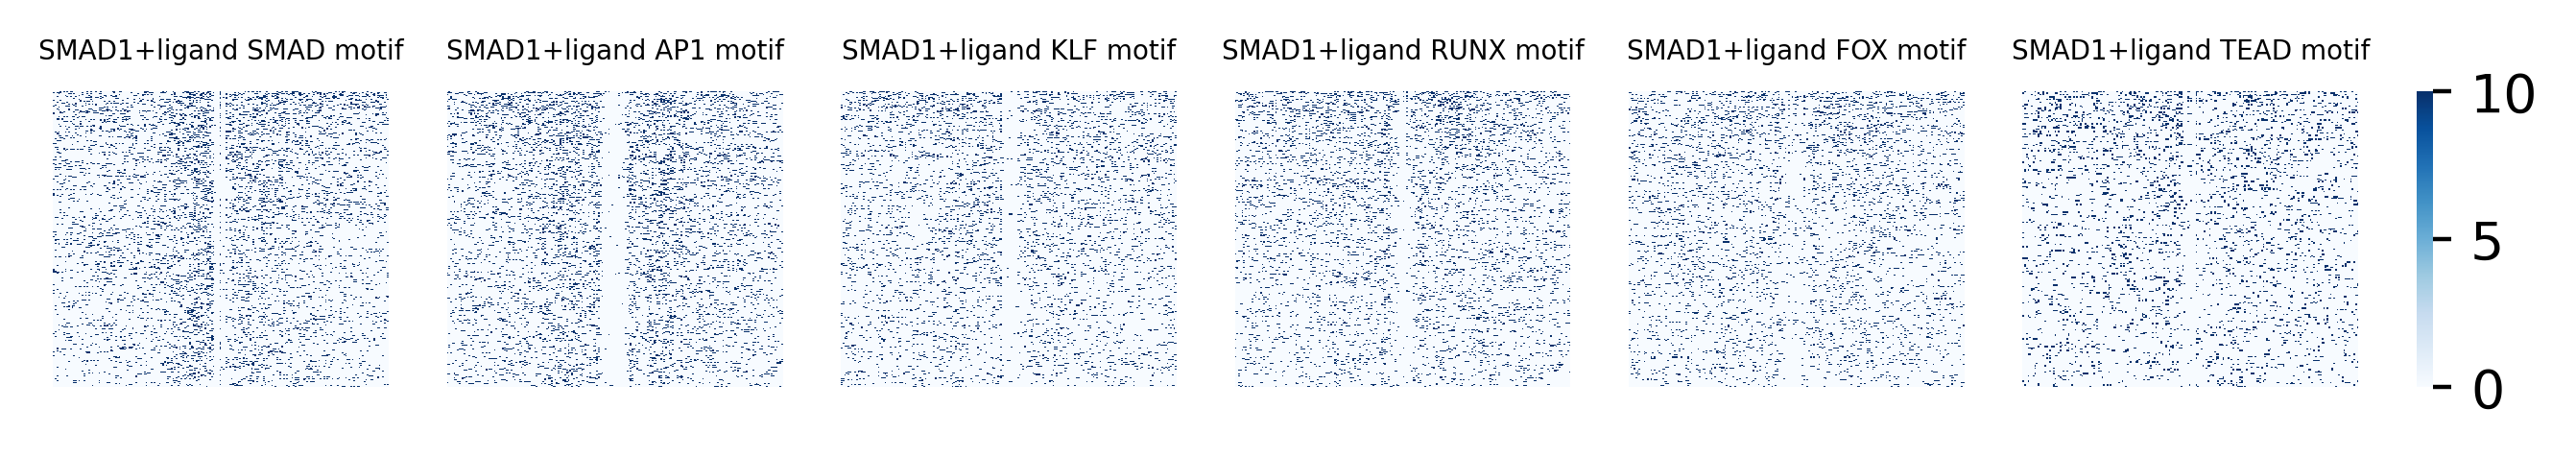

In [23]:
fig, ax = plt.subplots(1,7, width_ratios=[5,5,5,5,5,5,.25], figsize=(8,1), dpi=200)

indices = forhtmp['SMAD1_SMAD2wt_ligand_smad1_bmp_high_signals_on_motifs.parquet'].sum(axis=1).sort_values(ascending=False).index
sns.heatmap(forhtmp['SMAD1_SMAD2wt_ligand_smad1_bmp_high_signals_on_motifs.parquet'].loc[indices],
            cmap='Blues', vmin=0, vmax=10, ax=ax[0], yticklabels=False, xticklabels=False, cbar_ax = ax[-1], rasterized=True)

indices = forhtmp['GR_AP1wt_ligand_smad1_bmp_high_signals_on_motifs.parquet'].sum(axis=1).sort_values(ascending=False).index
sns.heatmap(forhtmp['GR_AP1wt_ligand_smad1_bmp_high_signals_on_motifs.parquet'].loc[indices],
            cmap='Blues', vmin=0, vmax=10, ax=ax[1], yticklabels=False, xticklabels=False, cbar=False, rasterized=True)

indices = forhtmp['GR_KLFwt_ligand_smad1_bmp_high_signals_on_motifs.parquet'].sum(axis=1).sort_values(ascending=False).index
sns.heatmap(forhtmp['GR_KLFwt_ligand_smad1_bmp_high_signals_on_motifs.parquet'].loc[indices],
            cmap='Blues', vmin=0, vmax=10, ax=ax[2], yticklabels=False, xticklabels=False, cbar=False, rasterized=True)

indices = forhtmp['GR_RUNXwt_ligand_smad1_bmp_high_signals_on_motifs.parquet'].sum(axis=1).sort_values(ascending=False).index
sns.heatmap(forhtmp['GR_RUNXwt_ligand_smad1_bmp_high_signals_on_motifs.parquet'].loc[indices],
            cmap='Blues', vmin=0, vmax=10, ax=ax[3], yticklabels=False, xticklabels=False, cbar=False, rasterized=True)

indices = forhtmp['GR_FOXwt_ligand_smad1_bmp_high_signals_on_motifs.parquet'].sum(axis=1).sort_values(ascending=False).index
sns.heatmap(forhtmp['GR_FOXwt_ligand_smad1_bmp_high_signals_on_motifs.parquet'].loc[indices],
            cmap='Blues', vmin=0, vmax=10, ax=ax[4], yticklabels=False, xticklabels=False, cbar=False, rasterized=True)

indices = forhtmp['GR_TEADwt_ligand_smad1_bmp_high_signals_on_motifs.parquet'].sum(axis=1).sort_values(ascending=False).index
sns.heatmap(forhtmp['GR_TEADwt_ligand_smad1_bmp_high_signals_on_motifs.parquet'].loc[indices],
            cmap='Blues', vmin=0, vmax=10, ax=ax[5], yticklabels=False, xticklabels=False, cbar=False, rasterized=True)

ax[0].set_title("SMAD1+ligand SMAD motif", size=5)
ax[1].set_title("SMAD1+ligand AP1 motif", size=5)
ax[2].set_title("SMAD1+ligand KLF motif", size=5)
ax[3].set_title("SMAD1+ligand RUNX motif", size=5)
ax[4].set_title("SMAD1+ligand FOX motif", size=5)
ax[5].set_title("SMAD1+ligand TEAD motif", size=5)

fig.savefig('figures/Fig1/smad1_lig_fotprnt_htmp.pdf')

In [24]:
allfoot_df = allfoot_df.drop(allfoot_df.filter(regex='halfsite|SMAD2|CTCF').columns, axis=1)

In [25]:
allfoot_df

GR_AP1_wt_ligand_hgr_wt_lig_signals_on_motifs.parquet  \
0.05                                          15.946578       
0.10                                          15.282137       
0.15                                          15.282137       
0.20                                          14.617696       
0.25                                          14.617696       
0.30                                          13.953255       
0.35                                          13.953255       
0.40                                          13.288815       
0.45                                          13.288815       
0.50                                          12.956594       
0.55                                          12.624374       
0.60                                          12.624374       
0.65                                          12.292154       
0.70                                          11.959933       
0.75                                          11.295492       
0.80                                          11.295492       
0.85                                          10.631052       
0.90                                          10.631052       
0.95                                           5.979967       
1.00                                           1.328881       

      GR_NR_wt_ligand_hgr_wt_lig_signals_on_motifs.parquet  \
0.05                                          21.594324      
0.10                                          20.597663      
0.15                                          19.933222      
0.20                                          19.933222      
0.25                                          19.601002      
0.30                                          18.936561      
0.35                                          18.604341      
0.40                                          17.939900      
0.45                                          17.607679      
0.50                                          16.943239      
0.55                                           8.969950      
0.60                                           8.969950      
0.65                                           8.969950      
0.70                                           8.969950      
0.75                                           8.637730      
0.80                                           8.305509      
0.85                                           8.305509      
0.90                                           1.993322      
0.95                                           1.328881      
1.00                                           0.332220      

      GR_RUNX_wt_ligand_hgr_wt_lig_signals_on_motifs.parquet  \
0.05                                          16.943239        
0.10                                          13.953255        
0.15                                          13.621035        
0.20                                           6.976628        
0.25                                           6.976628        
0.30                                           6.976628        
0.35                                           6.644407        
0.40                                           6.644407        
0.45                                           6.312187        
0.50                                           6.312187        
0.55                                           6.312187        
0.60                                           5.979967        
0.65                                           5.647746        
0.70                                           5.647746        
0.75                                           3.654424        
0.80                                           3.654424        
0.85                                           3.654424        
0.90                                           3.322204        
0.95                                           3.322204        
1.00                                           2.657763        

      GR_FOX_wt_ligand_hgr_wt_lig_

/tmp/ipykernel_547773/2804513839.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


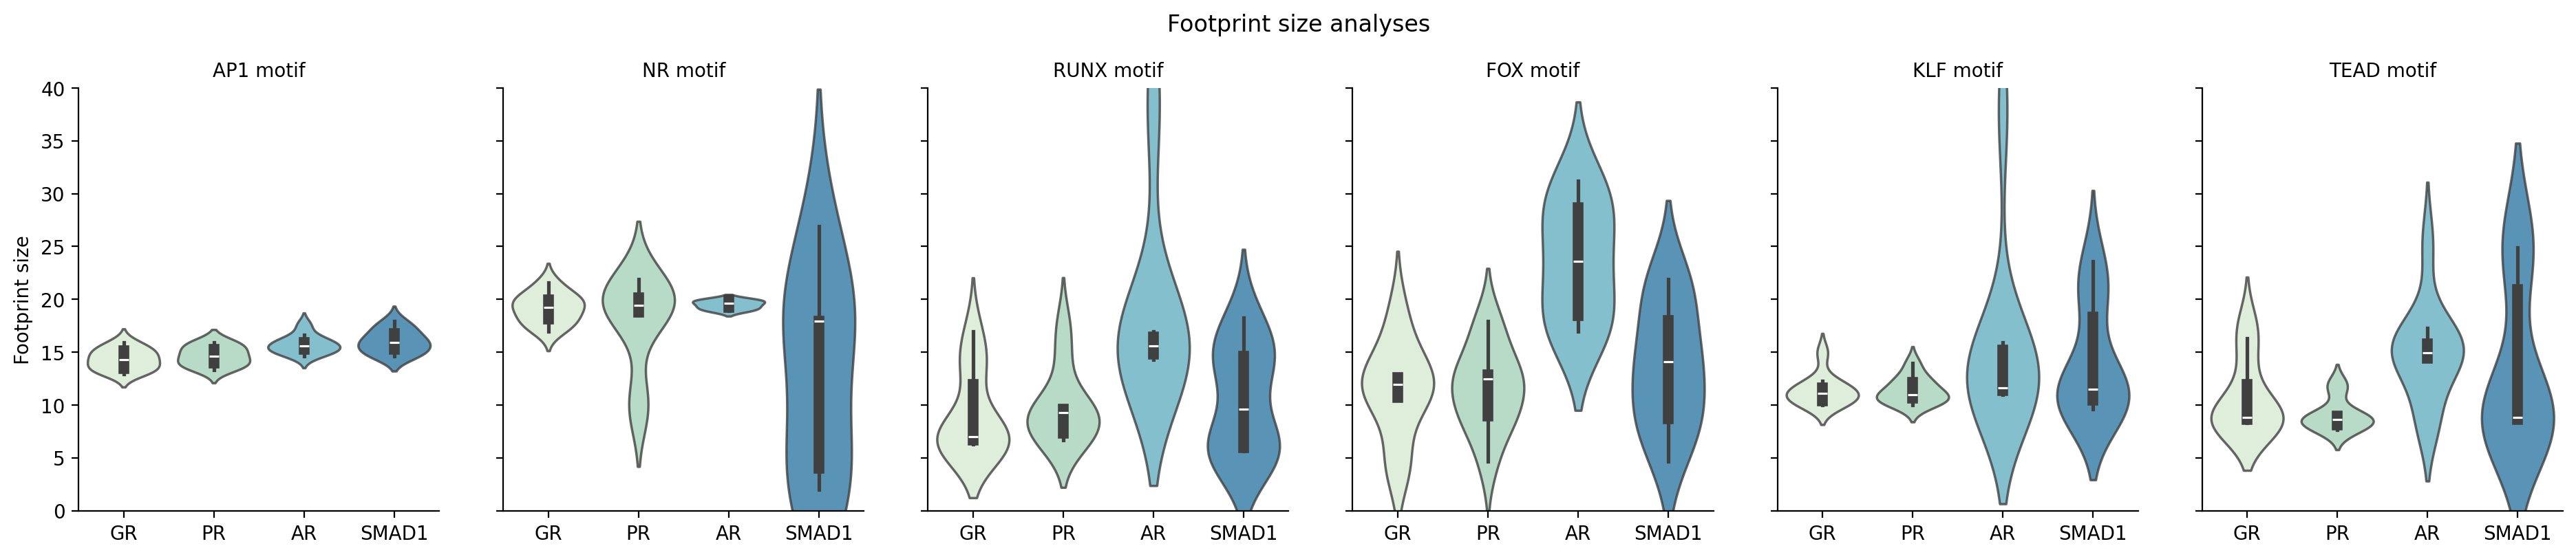

In [88]:
unstacked = allfoot_df.iloc[:10].unstack().reset_index()
unstacked.loc[:, 'motif'] = unstacked.level_0.apply(lambda x: x.split('_')[1])
unstacked.loc[:, 'factor'] = unstacked.level_0.apply(lambda x: x.split('ligand_')[-1].split('_signals_')[0])

unstacked = unstacked.drop('level_0', axis=1)
unstacked.replace('del_lbd', 'dlbd', inplace=True)

g = sns.catplot(
    unstacked, kind="violin",
    col="motif", y=0, x="factor",
    height=4, aspect=.8, sharey=True,native_scale=True, palette='GnBu', alpha=.8
)
g.set_axis_labels("", "Footprint size")
g.set_xticklabels(["GR", "PR", "AR","SMAD1"])
g.set_titles("{col_name} {col_var}")
g.fig.suptitle("Footprint size analyses", y=1.05)  # Adjust y to control the vertical position
g.set(ylim=(0, 40))
g.figure.savefig('figures/Fig1/fig1_fotprnt_dist.pdf')

/tmp/ipykernel_547773/3174383154.py:8: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=0)
/tmp/ipykernel_547773/3174383154.py:16: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  subf[ind].subplots_adjust(hspace=0)
/tmp/ipykernel_547773/3174383154.py:16: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  subf[ind].subplots_adjust(hspace=0)
/tmp/ipykernel_547773/3174383154.py:16: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  subf[ind].subplots_adjust(hspace=0)
/tmp/ipykernel_547773/3174383154.py:16: UserWarning: This figure was using a layout engine that is incompatible with subplo

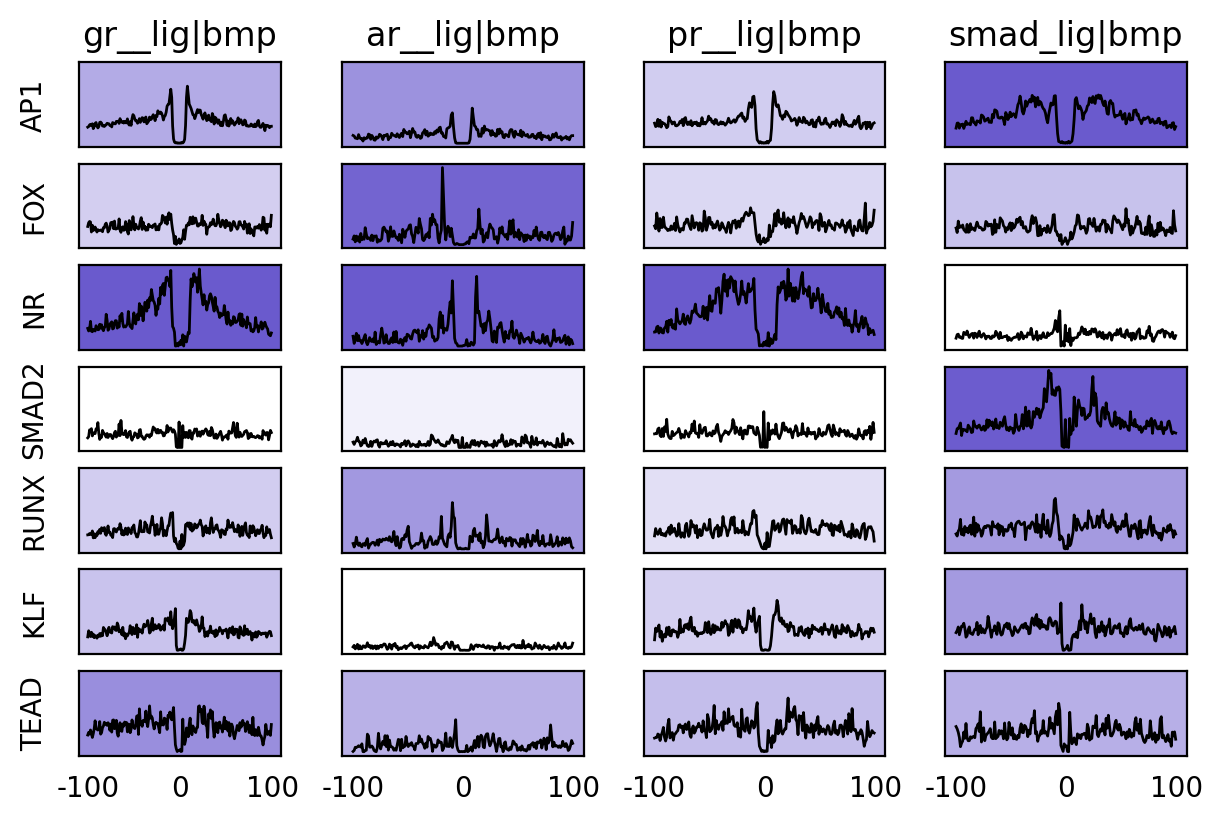

In [89]:
mottype = ['AP1', 'FOX', 'NR', 'SMAD2', 'RUNX', 'KLF', 'TEAD']
tftype =['gr_', 'ar_', 'pr_', 'smad']
muttype = ['lig|bmp']
colormap = sns.blend_palette(['white', 'slateblue'], as_cmap=True)
fig = plt.figure(figsize=(6,4), constrained_layout=True)

subf = fig.subfigures(1,len(mot_signals))
fig.subplots_adjust(wspace=0)
ind = 0

# palette = ['purple', 'slateblue', 'palevioletred', 'cadetblue']
for mut in muttype:
    for tf in tftype:
        tfmut = alldf.filter(regex=mut).filter(regex=tf)
        axes = subf[ind].subplots(len(mottype),1,sharey=True, sharex=True)
        subf[ind].subplots_adjust(hspace=0)
        axes[0].set_title(f'{tf}_{mut}')
        for mot, axi in zip(mottype, axes):
            to_plot = tfmut.filter(regex=mot)
            
            axi.plot(to_plot, c='k', lw=1)
            axi.set_yticklabels('')
            norm = plt.Normalize(vmin=tfmut.mean().min(), vmax=tfmut.mean().max())
            background_color = colormap(norm(to_plot.mean()))
            axi.set_facecolor(background_color)
            axi.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
            if ind == 0:
                axi.set_ylabel(mot)
        axi.set_xticks(np.arange(0,300,100), np.arange(-100,200,100))
        ind += 1
fig.savefig('figures/Fig1/fig1_fotprnt_mean.pdf')

In [90]:
enrich_gos = glob.glob('data_2/enrichment_*')

/tmp/ipykernel_547773/2065587910.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0)


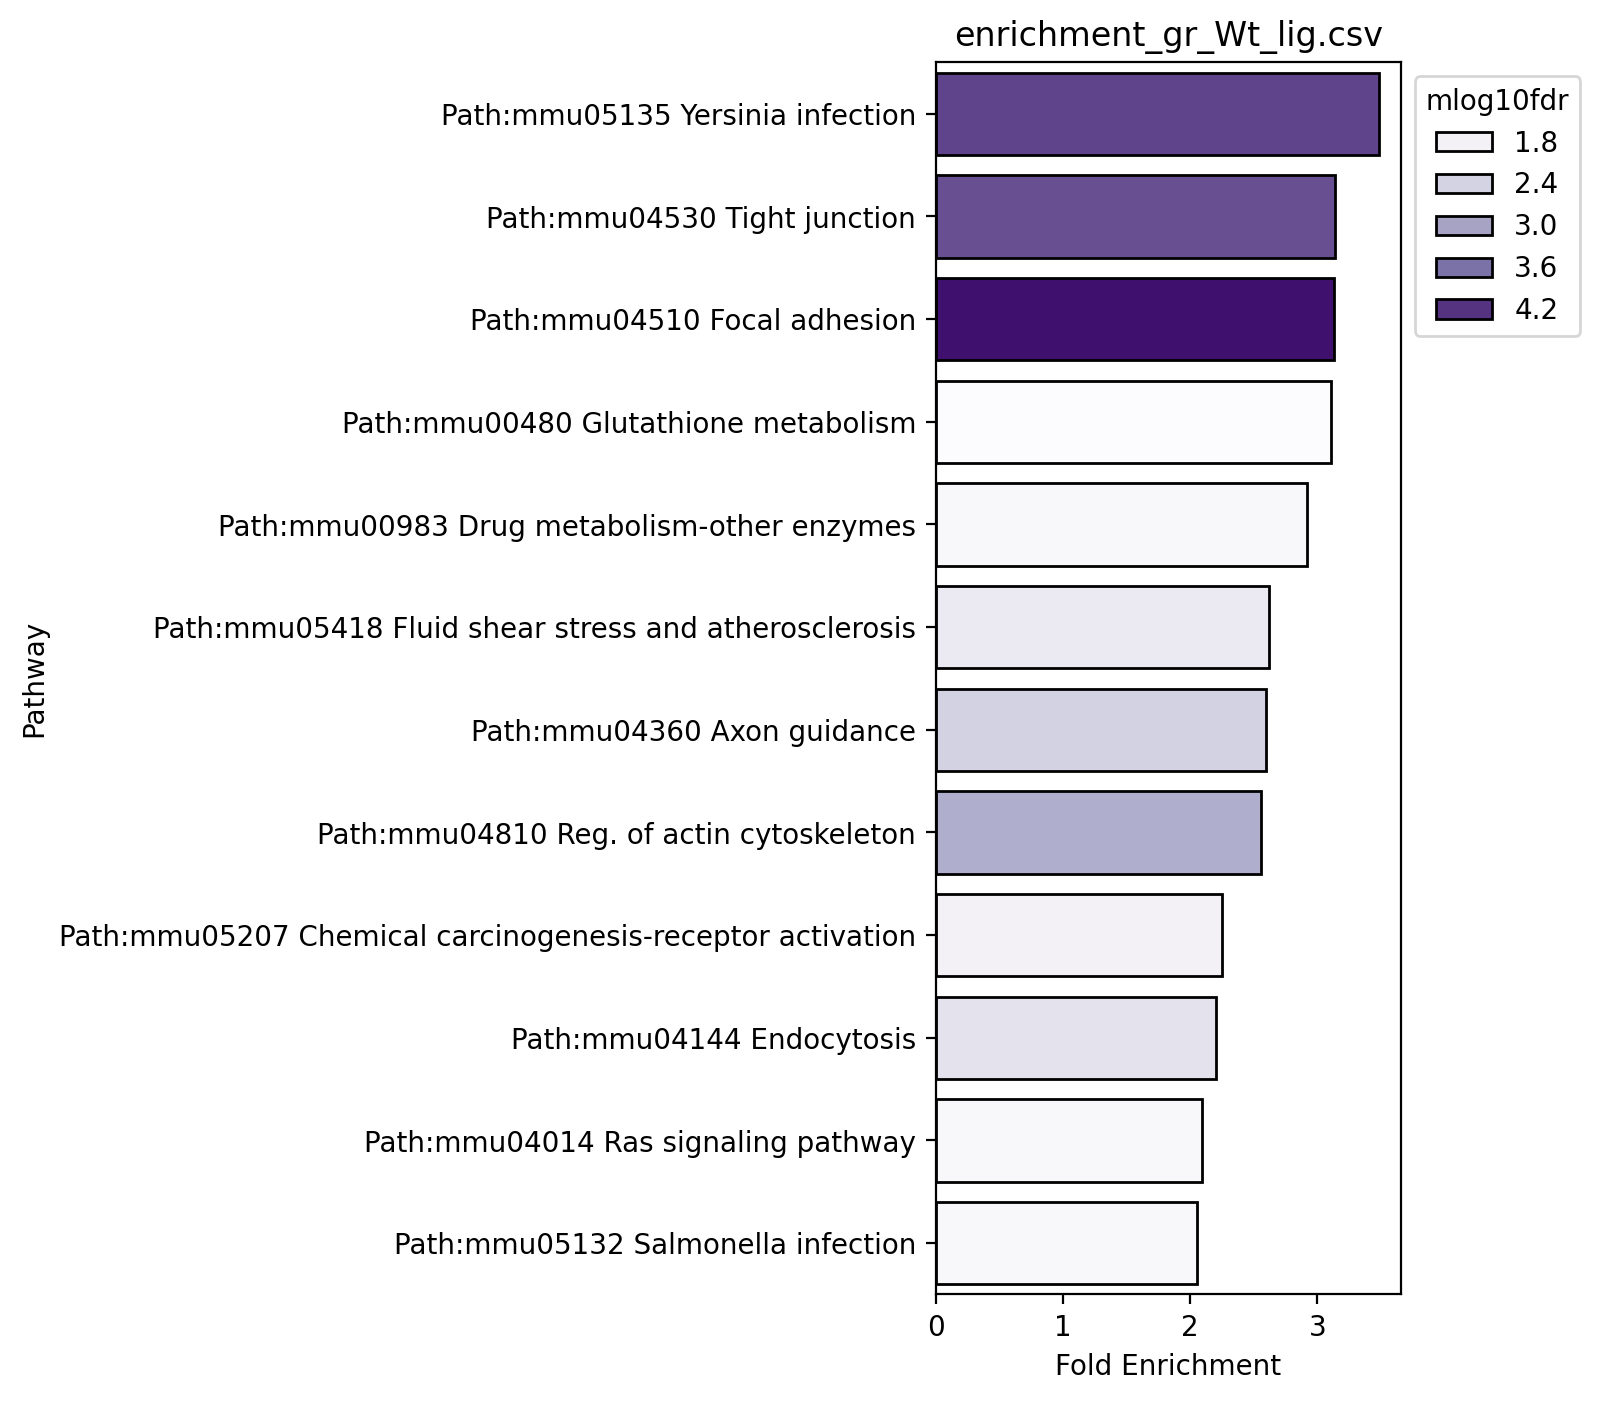

In [91]:
dat = pd.read_csv(enrich_gos[0])
dat.loc[:, 'mlog10fdr'] = -np.log10(dat.loc[:, 'Enrichment FDR'])
fig, ax = plt.subplots(1, figsize=(3,8))
s = sns.barplot(data=dat[dat['Fold Enrichment'] > 2], x='Fold Enrichment', y='Pathway', hue='mlog10fdr', palette='Purples', ec='k', ax=ax)
sns.move_legend(s, loc='best', bbox_to_anchor=[1,1])
ax.set_title(enrich_gos[0].split('/')[-1])
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
fig.savefig('figures/kedd.pdf')

In [92]:
t = metadata.filter(regex='lig|bmp', axis=0).filter(regex='nmumg', axis=0).loc[:, 'peaks_w_summits']

nmumg_fimo = sorted(glob.glob('combined_threshed_peaks_wsummits/output_fimo_fasta_*'))
arr = np.array(list((pd.Index(nmumg_fimo).str.split('output_fimo_fasta_').str[1].str.split('_fc10_'))))

pivoted = pd.DataFrame((arr[:,0], arr[:, 1], nmumg_fimo)).T\
.pivot(index=0, columns=1, values=2)\
.rename_axis(None, axis=1)\
.rename_axis('index', axis=0)

In [93]:
nmummg_wtlig_mot_locs = pivoted
md = {'smad1':'SMAD1', 'hgr':'GR', 'mar':'AR', 'hpr':'PR', 'ar':'AR', 'pr':'PR', 'gr':'GR'}

mot_num_table = defaultdict(list)
peak_shape = dict()
for key, value in t.to_dict().items():
    print(key)
    if key == 'nmumg_smad1':
        key = 'nmumg_smad1_bmp_high'
    clocs = nmummg_wtlig_mot_locs.filter(regex=md[key.split('_')[1]]).loc[key]
    lpeak = pr.read_bed(value)
    peak_shape[key] = len(lpeak)
    clocs = clocs.fillna('combined_threshed_peaks_wsummits/output_fimo_fasta_nmumg_smad1_bmp_high_fc10_SMAD1_HNF_mot')
    for cmot, cloc in clocs.reset_index().values:
        loaded_loc = pr.read_gff3(cloc + '/fimo.gff')
        mot_num_table[key].append((cmot, lpeak.join(loaded_loc).cluster().Cluster.max()))

nmumg_hgr_wt_lig


/home/labs/barkailab/vovam/.local/lib/python3.10/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}
/home/labs/barkailab/vovam/.local/lib/python3.10/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}
/home/labs/barkailab/vovam/.local/lib/python3.10/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain curr

nmumg_hpr_wt_lig


/home/labs/barkailab/vovam/.local/lib/python3.10/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}
/home/labs/barkailab/vovam/.local/lib/python3.10/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}
/home/labs/barkailab/vovam/.local/lib/python3.10/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain curr

nmumg_mar_wt_lig


/home/labs/barkailab/vovam/.local/lib/python3.10/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}
/home/labs/barkailab/vovam/.local/lib/python3.10/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}
/home/labs/barkailab/vovam/.local/lib/python3.10/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain curr

nmumg_smad1_bmp_high


/home/labs/barkailab/vovam/.local/lib/python3.10/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}
/home/labs/barkailab/vovam/.local/lib/python3.10/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}
/home/labs/barkailab/vovam/.local/lib/python3.10/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain curr

In [94]:

motn_Df = pd.DataFrame(mot_num_table).T.unstack().reset_index().drop('level_0', axis=1)
motn_Df.loc[:, 'mot_source'] = motn_Df.loc[:, 0].apply(lambda x: x[0])
motn_Df.loc[:, 'mot_len'] = motn_Df.loc[:, 0].apply(lambda x: x[1])
mot_table = motn_Df.drop(0, axis=1).pivot(index='level_1', columns='mot_source', values='mot_len')
motn_Df = pd.concat([motn_Df.set_index('level_1') , pd.DataFrame(peak_shape, index=['num_peaks']).T.loc[motn_Df.set_index('level_1').index]], axis=1).reset_index()
motn_Df.loc[:, 'type'] = motn_Df.mot_source.apply(lambda x: x.split('_')[1])

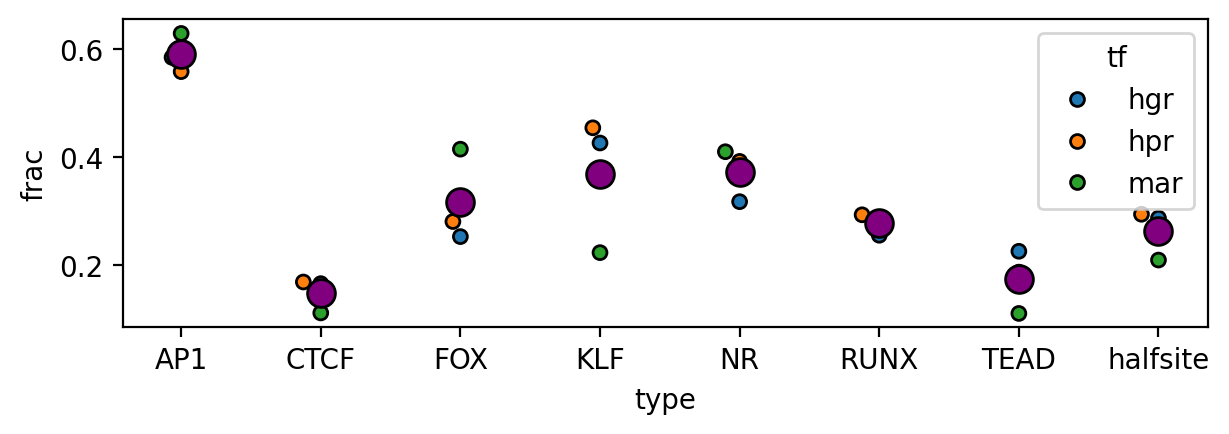

In [95]:
nmotsnmumg = motn_Df.\
set_index('mot_source').\
set_index('level_1').filter(regex='nmumg', axis=0).filter(regex='lig|lbd$|dbd', axis=0)
nmotsnmumg.loc[:, 'frac'] = (nmotsnmumg.mot_len / nmotsnmumg.num_peaks).values
nmotsnmumg = nmotsnmumg.reset_index()
nmotsnmumg.loc[:, 'tf'] = nmotsnmumg.iloc[:,0].apply(lambda x: x.split('_')[1])

fig, ax = plt.subplots(1, figsize=(7,2))
sns.swarmplot(data=nmotsnmumg.set_index('level_1').filter(regex='lig', axis=0), x='type', y='frac', c='lightgray', edgecolor='k', linewidth=1, hue='tf')
ax.scatter(data=nmotsnmumg.set_index('level_1').filter(regex='lig', axis=0).loc[:, ['type', 'frac']].groupby('type').mean().reset_index(), x='type', y='frac', zorder=20, s=100, c='purple', ec='k')
fig.savefig('figures/Fig1/peaks_mots_enrich.pdf')

In [96]:
sea = glob.glob('combined_threshed_peaks_wsummits/output_sea_fasta_*')

import os
def proc(x):
    return pd.read_csv(os.path.join(x, 'sea.tsv'), delimiter='\t').iloc[:-3, ]\
    .loc[:, ['ID', 'PVALUE']]\
    .rename({'PVALUE':x.split('_fasta_')[-1].split('_fc10')[0]},axis=1)\
    .set_index('ID')
#     pd.read_csv( 'combined_threshed_peaks_wsummits/output_sea_fasta_nmumg_mar_wt_lig_fc10.bed.fasta/sea.tsv',
#            delimiter='\t')

enrich_table = pd.concat([proc(x) for x in sea], axis=1)

ndata = enrich_table.filter(regex='nmumg').filter(regex='lig').filter(regex='AR|GR|PR', axis=0).filter(regex='KLF|AP1|NR|TEAD|FOX|RUNX', axis=0)


ndata.loc[:, 'mot_type'] = ndata.reset_index().loc[:, 'ID'].apply(lambda x: x.split('_')[-1]).values
pvals = -10 * np.log10(ndata.groupby('mot_type').median())
pvals = pvals.replace(np.inf, 2000)
pvals[pvals>100] = 100
pvals = pvals.reset_index().sort_values(by='nmumg_hgr_wt_lig', ascending=False)

/home/labs/barkailab/vovam/.local/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


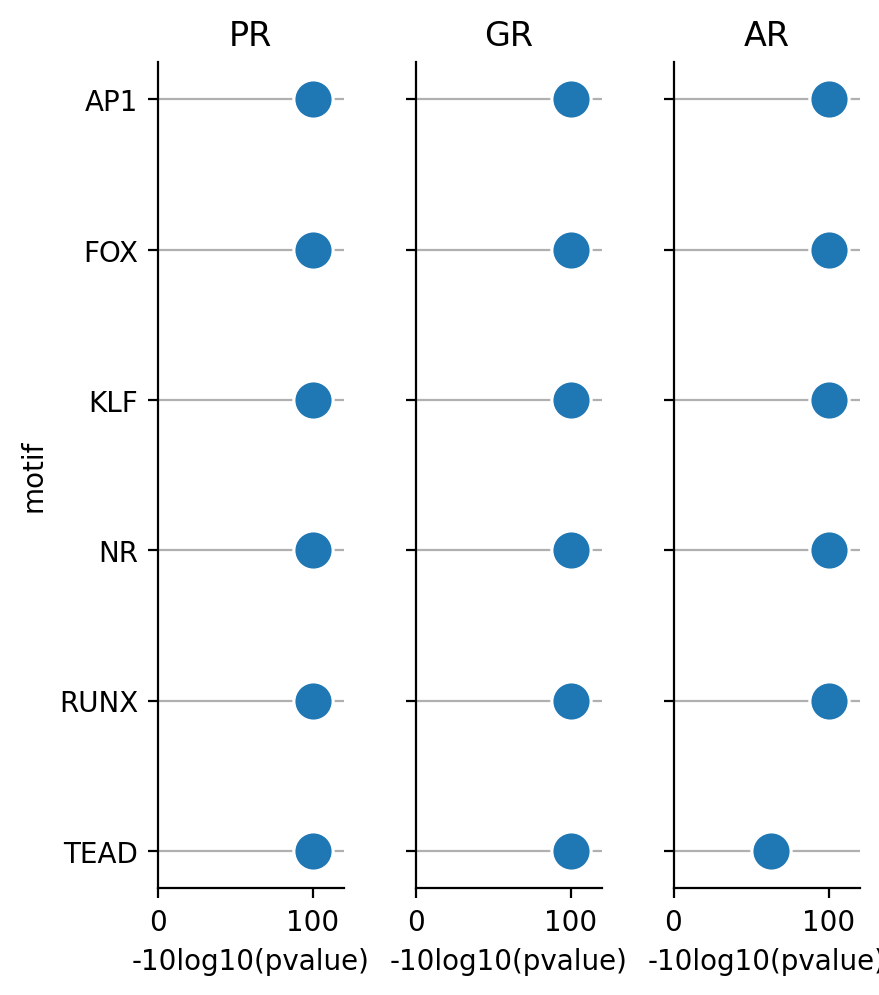

In [97]:
g = sns.PairGrid(pvals,
                 x_vars=pvals.columns[1:], y_vars=pvals.columns[0],
                 height=5, aspect=.3, layout_pad=1)

# Draw a dot plot using the stripplot function
g.map(sns.scatterplot, zorder=20, s=200)

g.set(xlim=(0, 120), xlabel= '-10log10(pvalue)', ylabel="motif")

for ax, title in zip(g.axes.flat, ['PR', 'GR', 'AR']):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)
g.fig.savefig('figures/Fig1/pvalues_motifs.pdf')

/home/labs/barkailab/vovam/.local/lib/python3.10/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}
/home/labs/barkailab/vovam/.local/lib/python3.10/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}
/home/labs/barkailab/vovam/.local/lib/python3.10/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain curr

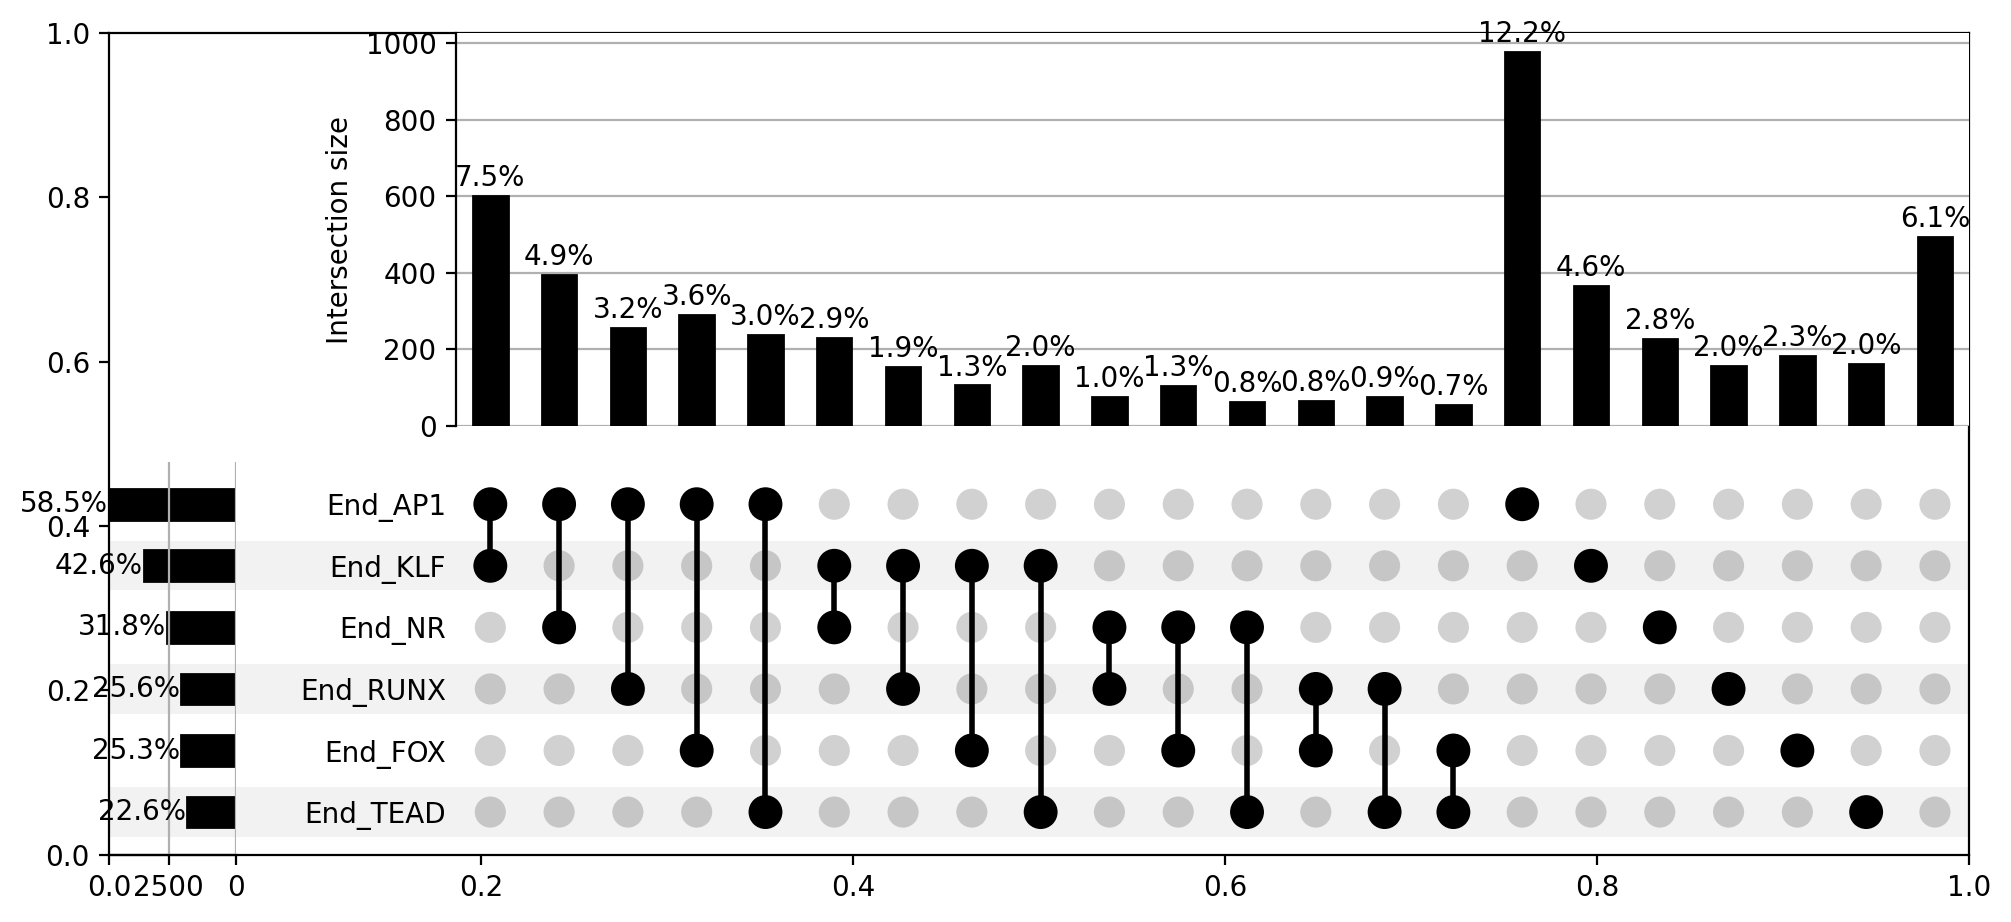

In [100]:
gr_wt_lig_fimod = pivoted.filter(regex='GR').filter(regex='nmumg_hgr_wt_lig', axis=0).drop(['GR_halfsite_mot', 'GR_CTCF_mot'], axis=1)
loaded_fimos = {key:pr.PyRanges(pr.read_gff3(os.path.join(value, 'fimo.gff')).df.loc[:, ['Chromosome', 'Start', 'End']]) for key, value in gr_wt_lig_fimod.T.squeeze().to_dict().items()}
gr_range_peaks = pr.PyRanges(peak.loc[:, ['Chromosome', 'Start', 'End']])
conc_fimo_peaks = lambda x: gr_range_peaks.join(loaded_fimos[x], how='left', suffix='_'+x.split('_')[1]).cluster().df.groupby("Cluster").agg(lambda x: list(x)[0]).iloc[:, -1:]
mot_occurences = (pd.concat(map(conc_fimo_peaks, list(loaded_fimos.keys())), axis=1)>0)*1
mot_occ_df = pd.concat([gr_range_peaks.df, mot_occurences.reset_index()], axis=1).drop("Cluster", axis=1)

binary_df = mot_occ_df.filter(regex='End_').astype(bool)

formatted_data = binary_df.groupby(binary_df.columns.tolist(), sort=False).size()
a = upsetplot.UpSet(formatted_data, show_percentages=True, max_degree=2, sort_by="-degree", sort_categories_by='-cardinality')
fig, ax= plt.subplots(1)
a.plot(fig)

fig.savefig('figures/Fig1/upset.pdf')

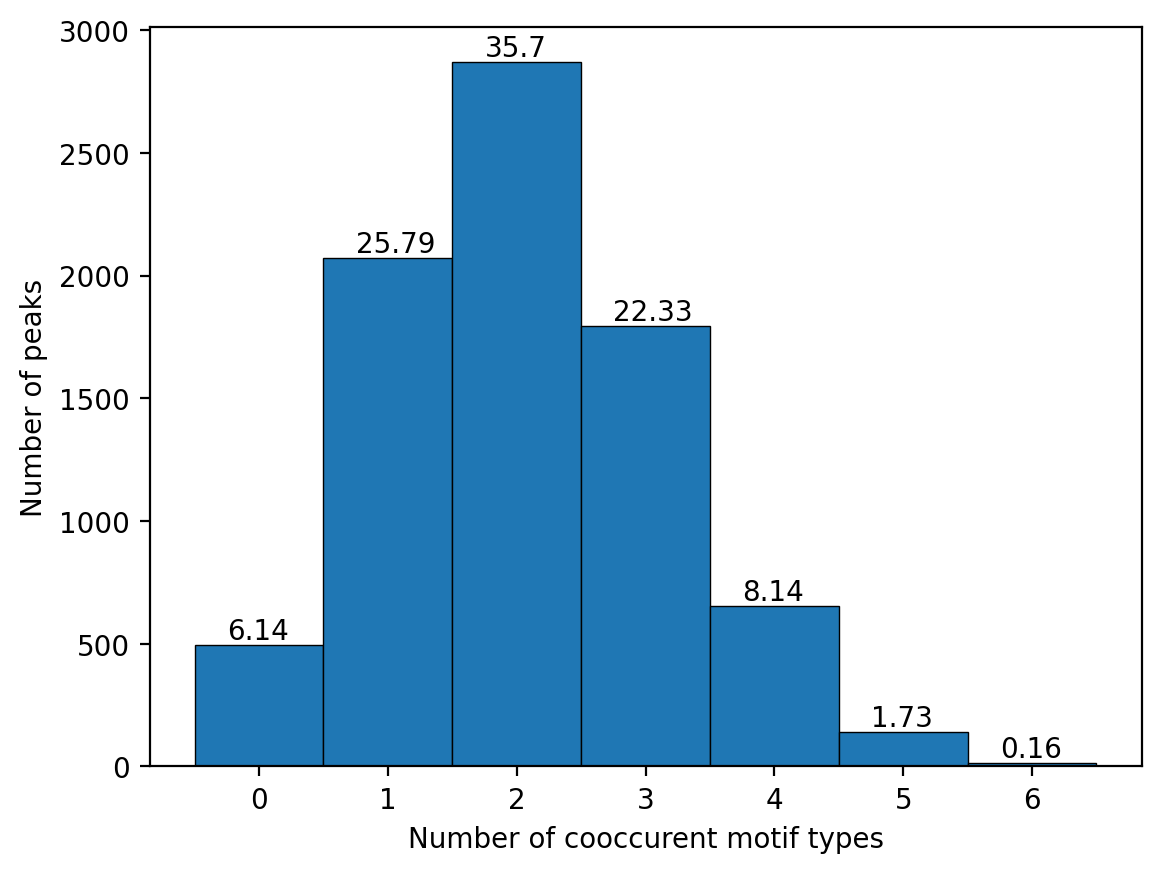

In [35]:
total_overlaps = pd.DataFrame(mot_occ_df.filter(regex='End_').sum(axis=1)).groupby(0).size()
total_overlaps_frac = (total_overlaps / total_overlaps.sum()) *100
fig, ax = plt.subplots(1)
ax.bar(total_overlaps.index, total_overlaps, ec='k', lw=.5, width=1)
for key, value in total_overlaps.to_dict().items():
    ax.text(key-.25, value+25, np.round(total_overlaps_frac.loc[key], 2))
    
ax.set_xlabel('Number of cooccurent motif types')
ax.set_ylabel('Number of peaks')
fig.savefig('figures/Fig1/coocc_hist.pdf')

/home/labs/barkailab/vovam/.local/lib/python3.10/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}
/home/labs/barkailab/vovam/.local/lib/python3.10/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}
/home/labs/barkailab/vovam/.local/lib/python3.10/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain curr

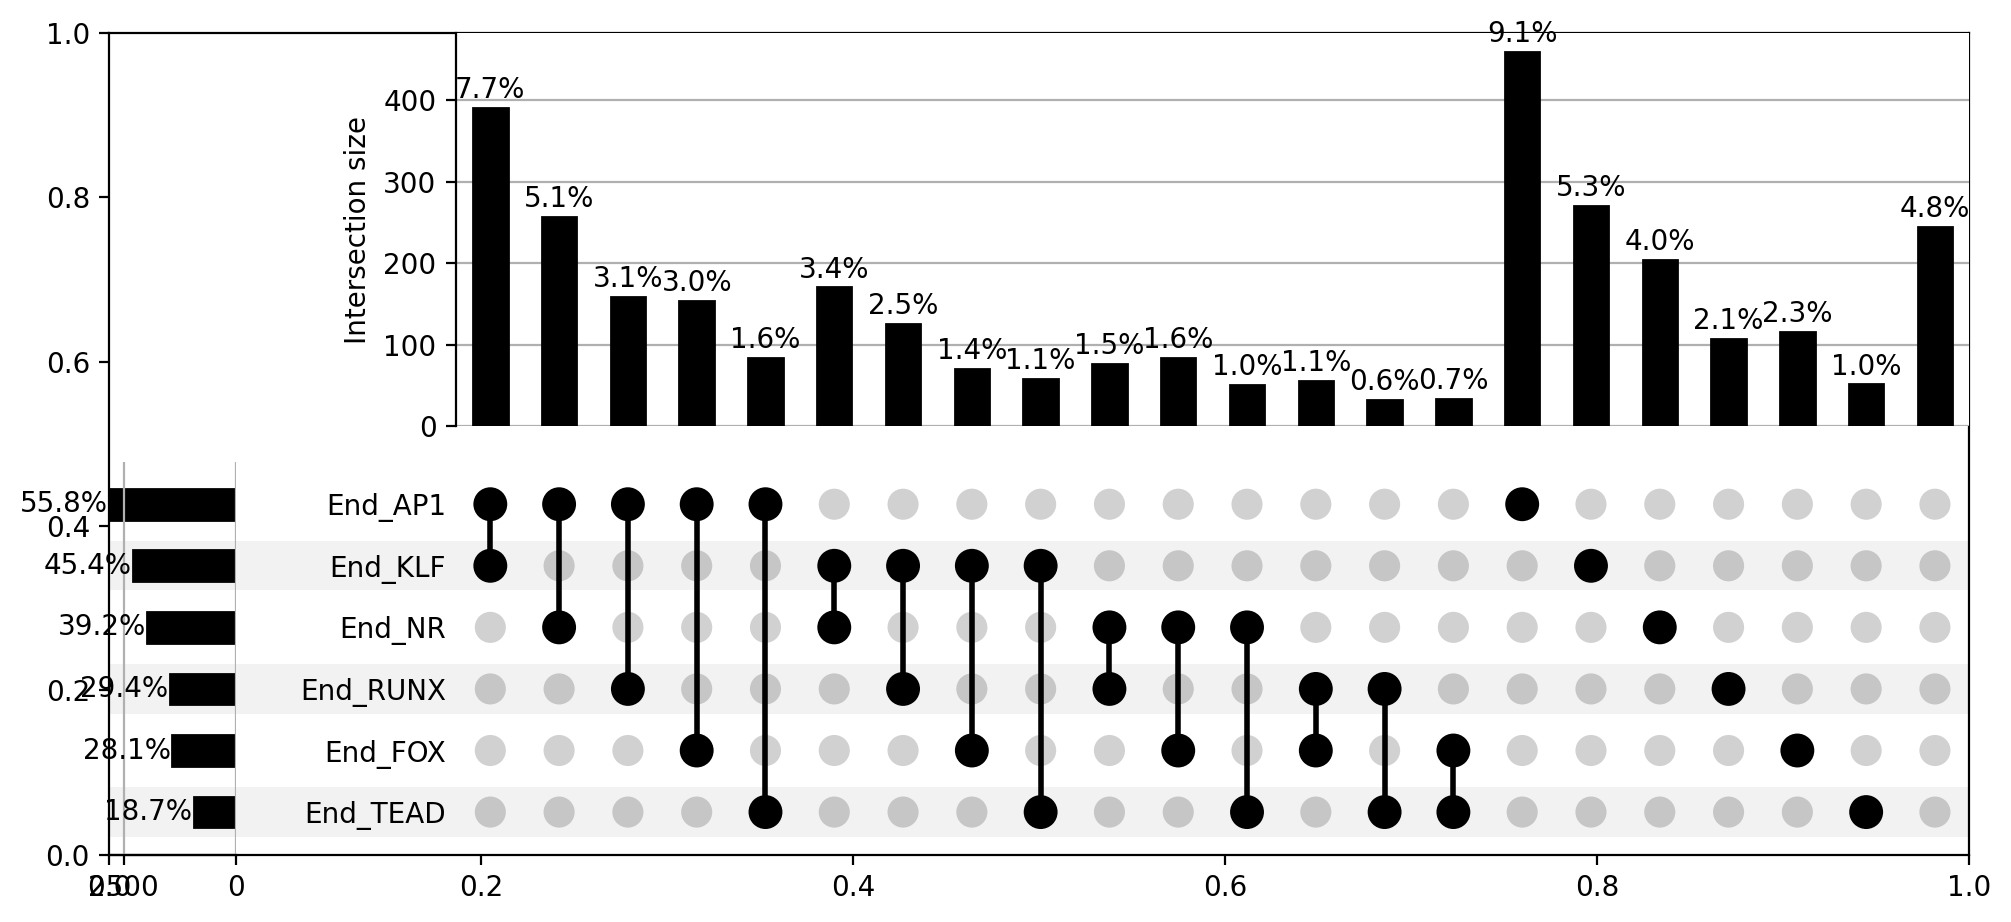

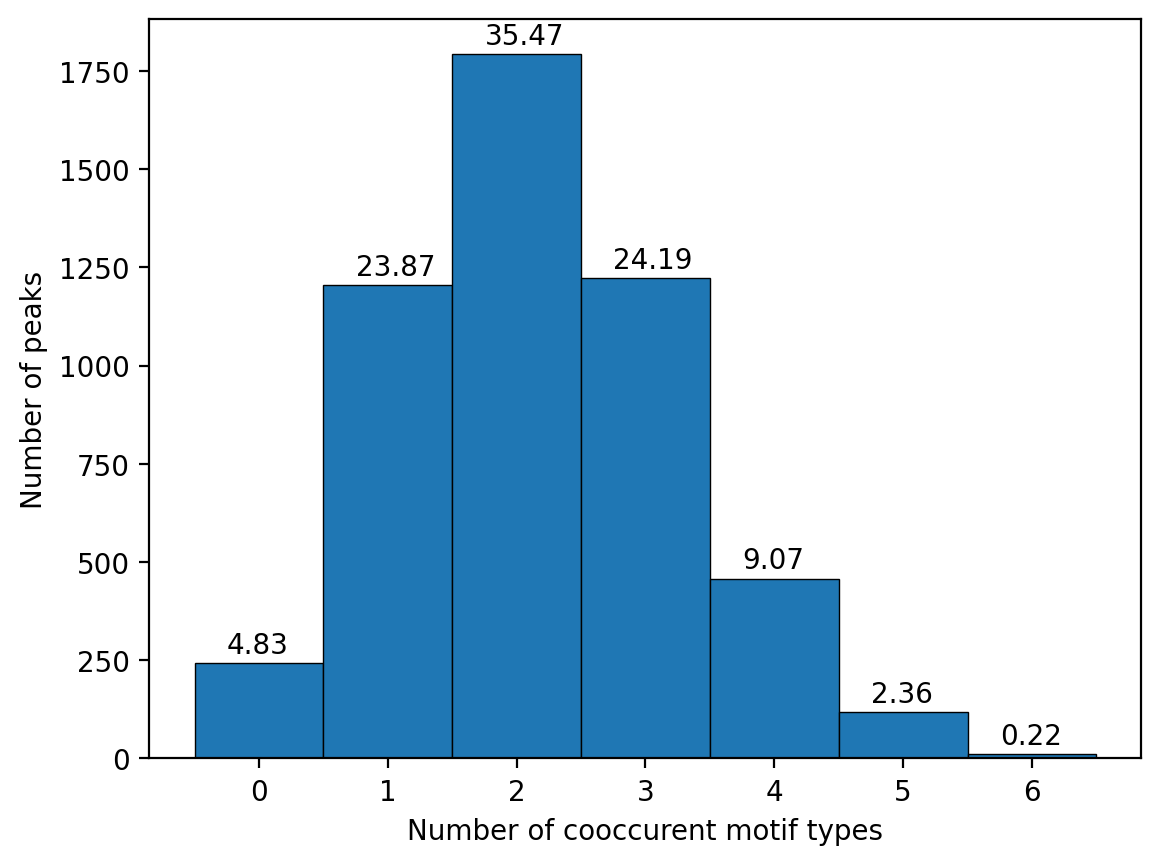

In [105]:
pr_wt_lig_fimod = pivoted.filter(regex='PR').filter(regex='nmumg_hpr_wt_lig', axis=0).drop(['PR_halfsite_mot', 'PR_CTCF_mot'], axis=1)
loaded_fimos = {key:pr.PyRanges(pr.read_gff3(os.path.join(value, 'fimo.gff')).df.loc[:, ['Chromosome', 'Start', 'End']]) for key, value in pr_wt_lig_fimod.T.squeeze().to_dict().items()}

prs = metadata.filter(regex='wt|lig', axis=0).filter(regex='nmumg', axis=0).filter(regex='pr', axis=0)
peak_pr = prs.iloc[-1,-1]
peak_pr = pr.read_bed(peak_pr).df

pr_range_peaks = pr.PyRanges(peak_pr.loc[:, ['Chromosome', 'Start', 'End']])
conc_fimo_peaks = lambda x: pr_range_peaks.join(loaded_fimos[x], how='left', suffix='_'+x.split('_')[1]).cluster().df.groupby("Cluster").agg(lambda x: list(x)[0]).iloc[:, -1:]
mot_occurences = (pd.concat(map(conc_fimo_peaks, list(loaded_fimos.keys())), axis=1)>0)*1
mot_occ_df = pd.concat([pr_range_peaks.df, mot_occurences.reset_index()], axis=1).drop("Cluster", axis=1)

binary_df = mot_occ_df.filter(regex='End_').astype(bool)

formatted_data = binary_df.groupby(binary_df.columns.tolist(), sort=False).size()
a = upsetplot.UpSet(formatted_data, show_percentages=True, max_degree=2, sort_by="-degree", sort_categories_by='-cardinality')
fig, ax= plt.subplots(1)
a.plot(fig)

fig.savefig('figures/Fig1/upset_pr.pdf')

total_overlaps = pd.DataFrame(mot_occ_df.filter(regex='End_').sum(axis=1)).groupby(0).size()
total_overlaps_frac = (total_overlaps / total_overlaps.sum()) *100
fig, ax = plt.subplots(1)
ax.bar(total_overlaps.index, total_overlaps, ec='k', lw=.5, width=1)
for key, value in total_overlaps.to_dict().items():
    ax.text(key-.25, value+25, np.round(total_overlaps_frac.loc[key], 2))
    
ax.set_xlabel('Number of cooccurent motif types')
ax.set_ylabel('Number of peaks')
fig.savefig('figures/Fig1/coocc_hist_pr.pdf')

/home/labs/barkailab/vovam/.local/lib/python3.10/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}
/home/labs/barkailab/vovam/.local/lib/python3.10/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}
/home/labs/barkailab/vovam/.local/lib/python3.10/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain curr

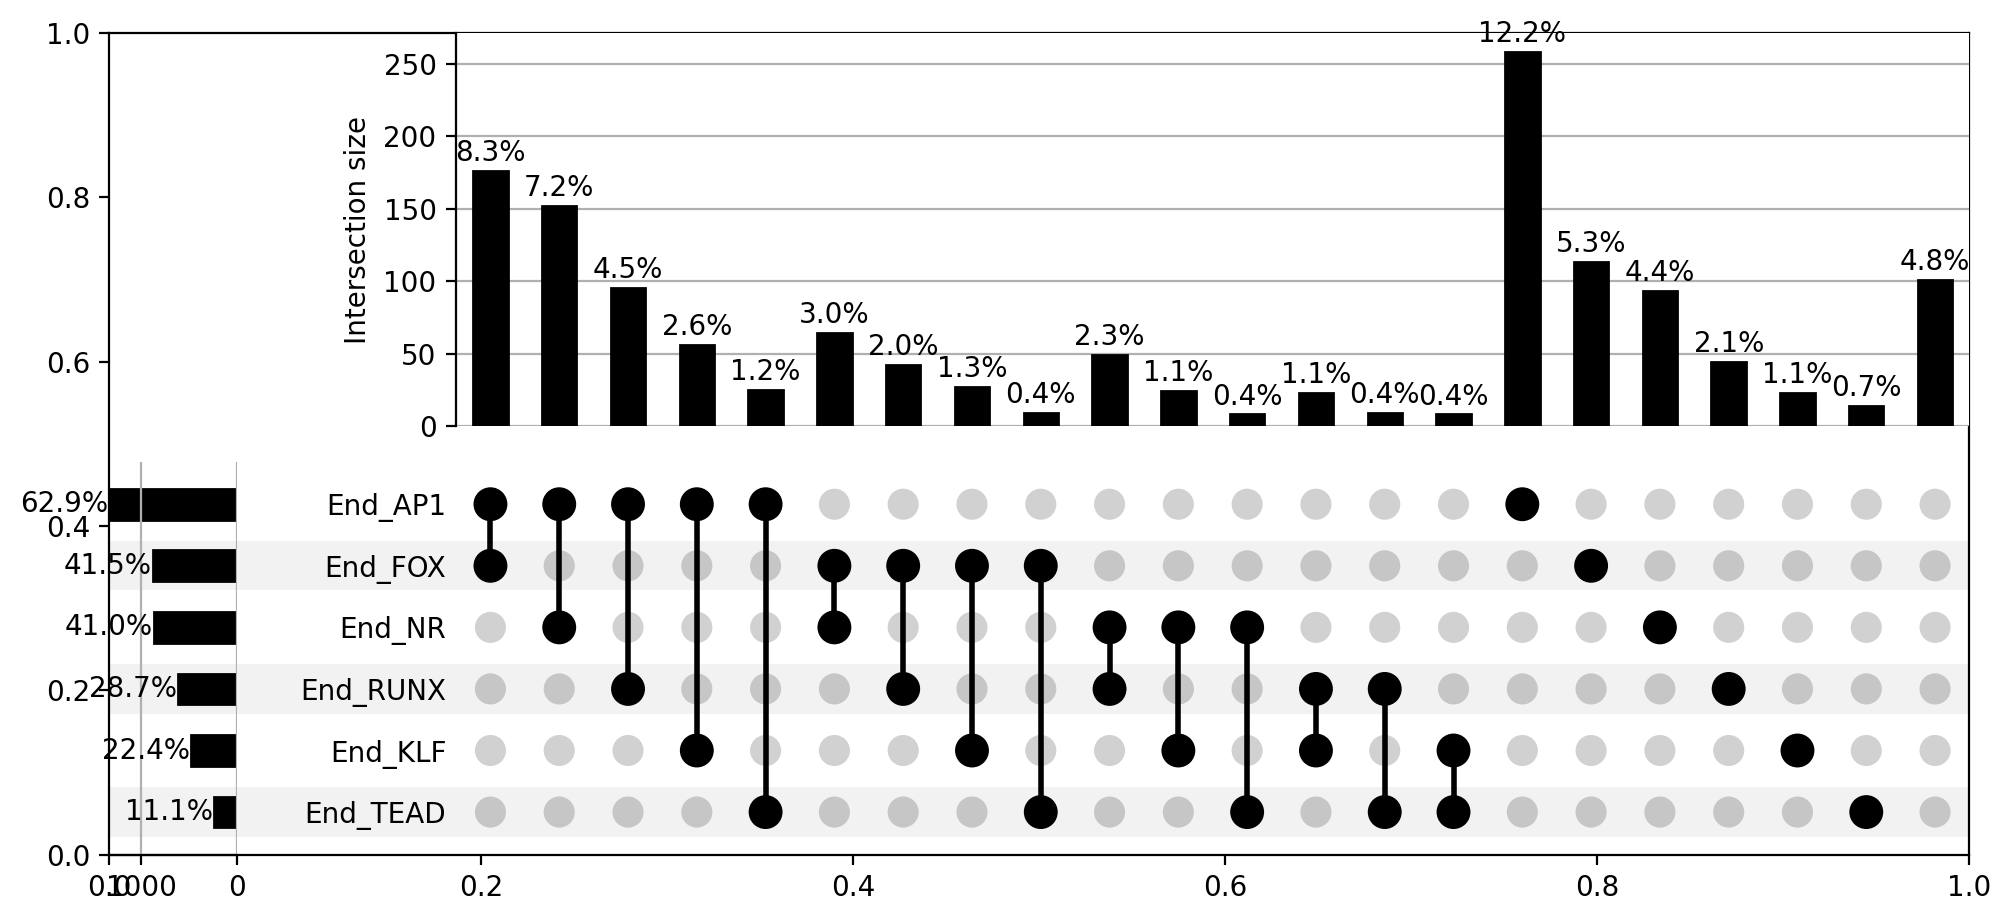

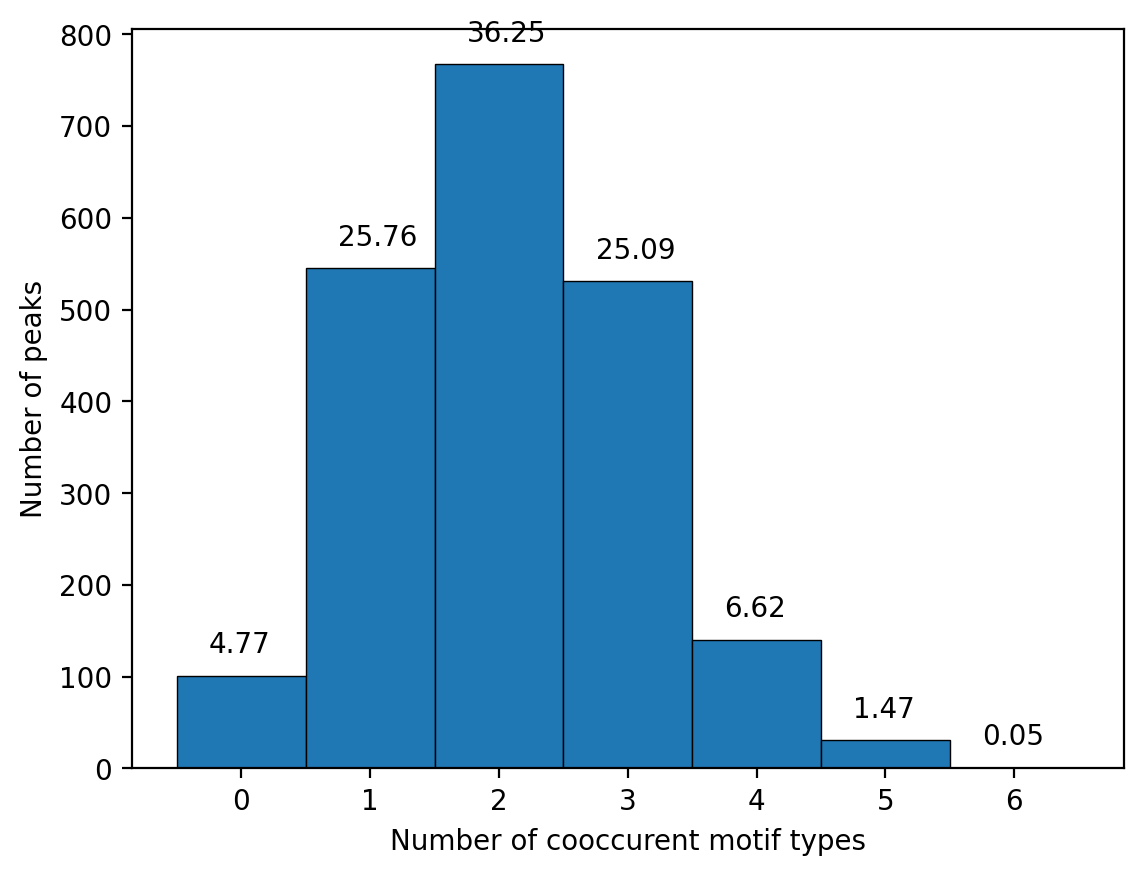

In [106]:
pr_wt_lig_fimod = pivoted.filter(regex='AR').filter(regex='nmumg_mar_wt_lig', axis=0).drop(['AR_halfsite_mot', 'AR_CTCF_mot'], axis=1)
loaded_fimos = {key:pr.PyRanges(pr.read_gff3(os.path.join(value, 'fimo.gff')).df.loc[:, ['Chromosome', 'Start', 'End']]) for key, value in pr_wt_lig_fimod.T.squeeze().to_dict().items()}

ars = metadata.filter(regex='wt|lig', axis=0).filter(regex='nmumg', axis=0).filter(regex='ar', axis=0)
peak_ar = ars.iloc[-1,-1]
peak_ar = pr.read_bed(peak_ar).df

ar_range_peaks = pr.PyRanges(peak_ar.loc[:, ['Chromosome', 'Start', 'End']])
conc_fimo_peaks = lambda x: ar_range_peaks.join(loaded_fimos[x], how='left', suffix='_'+x.split('_')[1]).cluster().df.groupby("Cluster").agg(lambda x: list(x)[0]).iloc[:, -1:]
mot_occurences = (pd.concat(map(conc_fimo_peaks, list(loaded_fimos.keys())), axis=1)>0)*1
mot_occ_df = pd.concat([ar_range_peaks.df, mot_occurences.reset_index()], axis=1).drop("Cluster", axis=1)

binary_df = mot_occ_df.filter(regex='End_').astype(bool)

formatted_data = binary_df.groupby(binary_df.columns.tolist(), sort=False).size()
a = upsetplot.UpSet(formatted_data, show_percentages=True, max_degree=2, sort_by="-degree", sort_categories_by='-cardinality')
fig, ax= plt.subplots(1)
a.plot(fig)

fig.savefig('figures/Fig1/upset_ar.pdf')

total_overlaps = pd.DataFrame(mot_occ_df.filter(regex='End_').sum(axis=1)).groupby(0).size()
total_overlaps_frac = (total_overlaps / total_overlaps.sum()) *100
fig, ax = plt.subplots(1)
ax.bar(total_overlaps.index, total_overlaps, ec='k', lw=.5, width=1)
for key, value in total_overlaps.to_dict().items():
    ax.text(key-.25, value+25, np.round(total_overlaps_frac.loc[key], 2))
    
ax.set_xlabel('Number of cooccurent motif types')
ax.set_ylabel('Number of peaks')
fig.savefig('figures/Fig1/coocc_hist_ar.pdf')

/home/labs/barkailab/vovam/.local/lib/python3.10/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}
/home/labs/barkailab/vovam/.local/lib/python3.10/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}


In [37]:

nr_range = pr.PyRanges(pr.read_gff3('combined_threshed_peaks_wsummits/output_fimo_fasta_nmumg_hgr_wt_lig_fc10_GR_NR_mot/fimo.gff').df.loc[:, ["Chromosome", 'Start', 'End']])

for name,i in loaded_fimos.items():
    if name == 'GR_NR_mot':
        continue
    nr_range = nr_range.join(i, slack=500, how='outer', suffix="_" + name.split('_')[1])
nr_range = nr_range.df

# If you want to use the motif strands, you will need to find them from here
nr_range = nr_range.loc[:, ['Chromosome', 'Start', 'End', 'Start_AP1',
       'End_AP1', 'Start_FOX','End_FOX' ,'Start_TEAD',
       'End_TEAD', 'Start_KLF', 'End_KLF', 'Start_RUNX',
       'End_RUNX',]]
nr_range = nr_range.replace(-1, np.nan)
nr_range.columns = ['Chromosome', 'Start_NR', 'End_NR', 'Start_AP1', 'End_AP1', 'Start_FOX',
       'End_FOX', 'Start_TEAD', 'End_TEAD', 'Start_KLF', 'End_KLF',
       'Start_RUNX', 'End_RUNX']
for i in ['NR', 'AP1', 'FOX', 'TEAD', 'KLF', 'RUNX']:
    cd = nr_range.loc[:, [f'Start_{i}', f'End_{i}']]
    mid = cd.iloc[:, 0] + np.ceil(((cd.iloc[:, 1] - cd.iloc[:, 0])/2))
    nr_range.loc[:, f'{i}_Mid'] = mid.values


mid_motifs = nr_range.loc[:, ['Chromosome', 'NR_Mid', 'AP1_Mid', 'FOX_Mid', 'TEAD_Mid', 'KLF_Mid', 'RUNX_Mid']]

for mid in ['NR_Mid', 'AP1_Mid', 'FOX_Mid', 'TEAD_Mid', 'KLF_Mid', 'RUNX_Mid']:
    distances = nr_range.filter(regex='Mid').apply(lambda x: x - nr_range.loc[:, mid]).drop(mid, axis=1)
    distances.columns = ["{}_minus_{}".format(x.replace("_Mid", ''), mid.replace('_Mid', '')) for x in distances.columns]
    mid_motifs = pd.concat([mid_motifs, distances], axis=1)
mid_motifs.loc[:, 'dummy_strand'] = '+'
coocc = (mid_motifs.filter(regex='Mid')>0) * 1
coocc.columns = [x.replace("_Mid", '_Occ') for x in coocc.columns]
mid_motifs.loc[:, 'unique'] = np.nan


for col in coocc.columns:
    cun = (coocc[coocc[col]==1].drop(col, axis=1).sum(axis=1)==0)
    mid_motifs.loc[cun[cun].index, 'unique'] = col.replace('_Occ', '')
    
main_peaks_pyrange = pr.PyRanges(peak.loc[:, ['Chromosome', 'Start', 'End']])
npeaks = main_peaks_pyrange.df.shape[0]


/tmp/ipykernel_4163413/3281227967.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'NR' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  mid_motifs.loc[cun[cun].index, 'unique'] = col.replace('_Occ', '')
/home/labs/barkailab/vovam/.local/lib/python3.10/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}


In [38]:
def average_bgs(path_list, ):
    con = pl.concat([pl.read_parquet(x) for x in path_list])\
    .groupby(['Chromosome', 'Start', 'End']).sum()\
    .with_columns((pl.col('Normalized_Reads')/len(path_list)).alias('mean_norm_reads'),
                  (pl.col('Name')/len(path_list)).alias('mean_raw_reads'),
                  pl.col('Chromosome').cast(str))\
    .sort(by=['Chromosome', 'Start'])

    return con


def process_window_peaks(n_peaks: pd.DataFrame, avbgs: pl.DataFrame, window: int = 1000, mid_col: str = 'Middle', strand_col: str = 'Strand'):
    """
    Process windowed peak regions and extract normalized read values.

    Parameters:
        n_peaks (pd.DataFrame): DataFrame containing peaks with columns ['Chromosome', 'middle', 'strand'].
        avbgs (pl.DataFrame): Polars DataFrame with columns ['Chromosome', 'Start', 'End', 'mean_norm_reads'].
        window (int): Window size around the mid_motif_peak (default is 200).

    Returns:
        list: List of normalized read arrays, adjusted for strand orientation.
    """
    signals = []

    for chrom, mid, strand in n_peaks[['Chromosome', mid_col, strand_col]].values:
        a = np.zeros(window)

        coords = avbgs.filter(
            (pl.col('Chromosome') == chrom) &
            (pl.col('Start') >= (int(mid) - (window / 2))) &
            (pl.col('End') <= (int(mid) + (window / 2)))
        ).select(['Start', 'mean_norm_reads']) \
         .with_columns(pl.col('Start') - (int(mid) - (window / 2))) \
         .sort(['Start']) \
         .to_numpy()

        a[coords[:, 0].astype(int)] = coords[:, 1]

        signals.append(a if strand == '+' else a[::-1])

    return signals

In [39]:
avebw = average_bgs(gr.loc[:, ['NormBG']].values.T[0][-1])


/tmp/ipykernel_4163413/3868032547.py:3: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  .groupby(['Chromosome', 'Start', 'End']).sum()\


In [40]:


dfd = dict()
for i in ['NR', 'AP1', 'RUNX', 'FOX', 'TEAD', 'KLF']:
    print(i)
    can = mid_motifs.query("unique == @i")
    nmot = can.shape[0]
    can = can.loc[:, ['Chromosome', f'{i}_Mid', 'dummy_strand']]
    can.loc[:, 'dindex'] = can.Chromosome.astype(str) + ':' + can.loc[:, f'{i}_Mid'].astype(str)+ ':' + can.dummy_strand.astype(str)
    can = can.set_index('dindex')
    can = can[~can.index.duplicated()]
    
    sigs = process_window_peaks(can, avebw, 1000,f'{i}_Mid', 'dummy_strand')
    df = pd.DataFrame(sigs)
    dfd[i] = df


NR
AP1
RUNX
FOX
TEAD
KLF


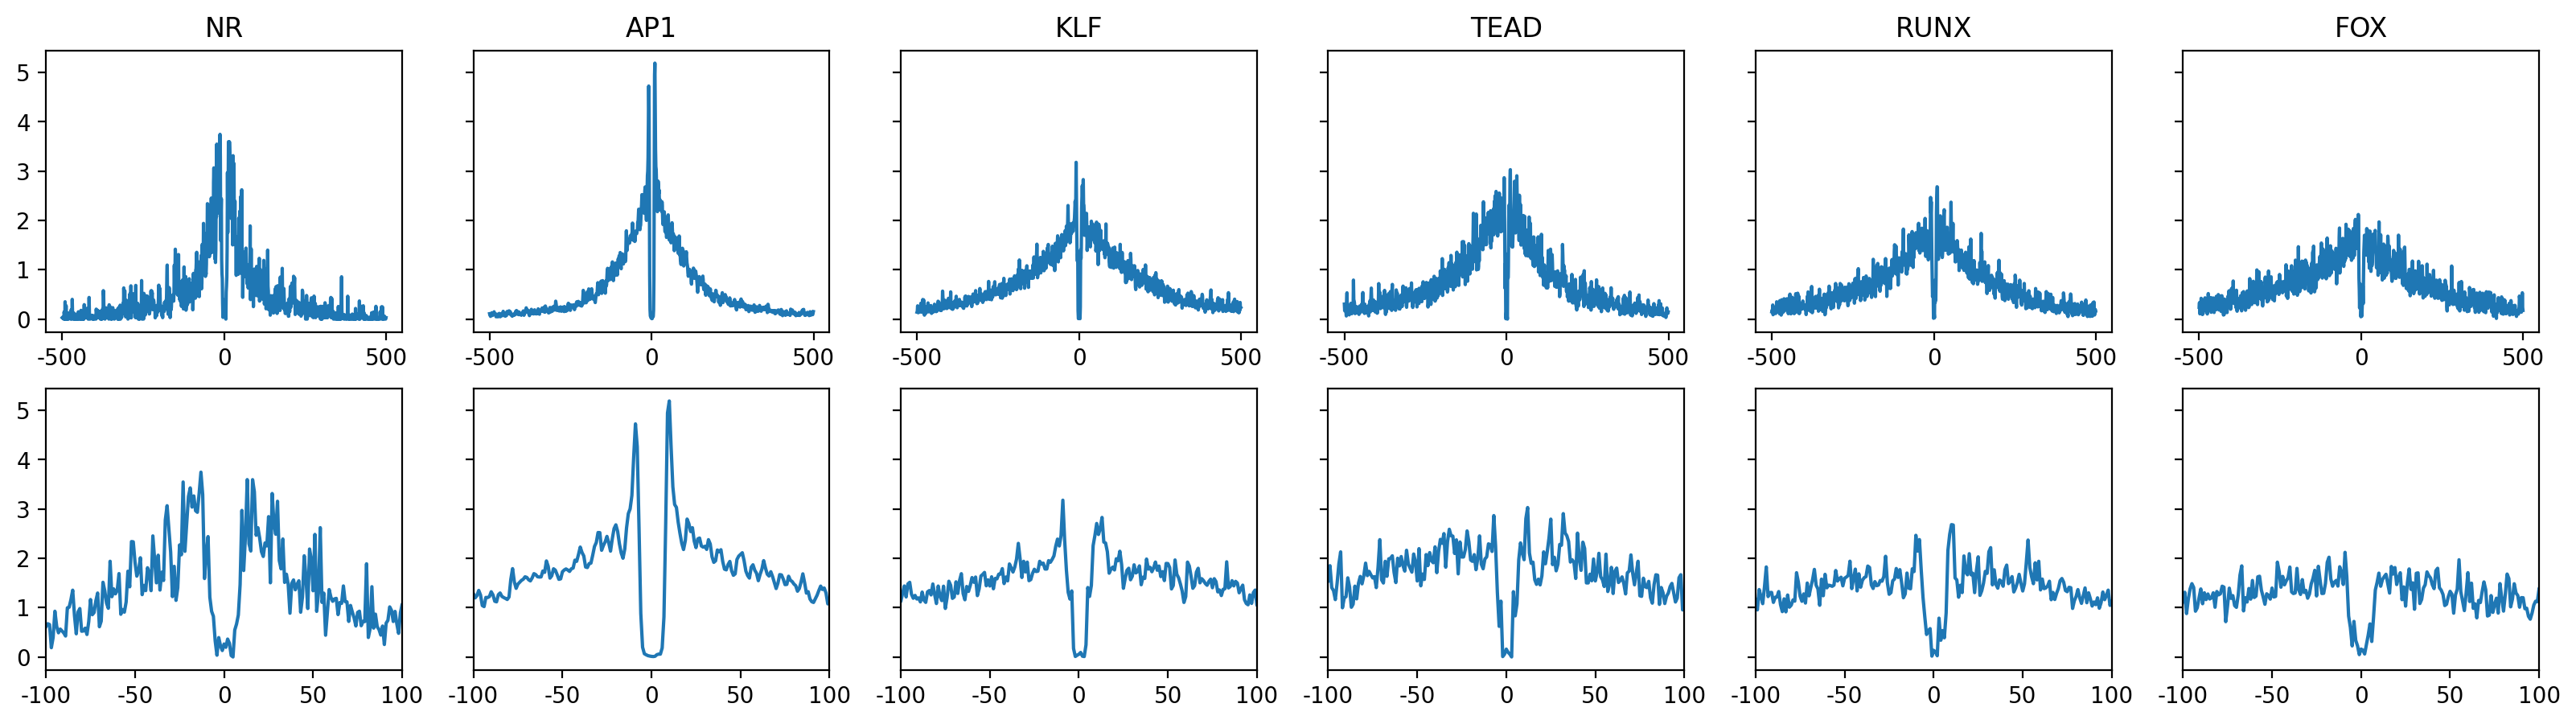

In [41]:
# fig, axes = plt.subplots(2,6, sharey=True, figsize=(20,5), sharex=False)

# ax = axes[0,:]
# dfd['NR'].mean().plot(ax=ax[0])
# dfd['AP1'].mean().plot(ax=ax[1])
# dfd['KLF'].mean().plot(ax=ax[2])
# dfd['TEAD'].mean().plot(ax=ax[3])
# dfd['RUNX'].mean().plot(ax=ax[4])
# dfd['FOX'].mean().plot(ax=ax[5])

# # ax[0].set_xlim([400,600])

# for i,axi in zip('NR,AP1,KLF,TEAD,RUNX,FOX'.split(','), ax):
#     axi.set_title(i)
#     axi.set_xticks(np.arange(0,1500,500), np.arange(-500,1000,500))
    
# ax = axes[1,:]
# dfd['NR'].mean().plot(ax=ax[0])
# dfd['AP1'].mean().plot(ax=ax[1])
# dfd['KLF'].mean().plot(ax=ax[2])
# dfd['TEAD'].mean().plot(ax=ax[3])
# dfd['RUNX'].mean().plot(ax=ax[4])
# dfd['FOX'].mean().plot(ax=ax[5])


# for i,axi in zip('NR,AP1,KLF,TEAD,RUNX,FOX'.split(','), ax):
#     axi.set_xlim([400,600])

#     axi.set_xticks(np.arange(400,650,50), np.arange(-100,150,50))
    
# fig.savefig('figures/Fig1/fig1_2_mean_single_occ_mots.pdf')

In [42]:
nr_comps = mid_motifs.filter(regex='Chromosome|NR_')

means_dist = defaultdict(dict)
fps = dict()
for i in ['AP1', 'KLF', 'RUNX', 'FOX', 'TEAD']:
    print(i)
    trial = nr_comps.filter(regex=f'Mid|{i}|Chrom').dropna()
    trial.loc[:, 'Strand'] = trial.iloc[:, -1].apply(lambda x: '+' if x>0 else '-')
    trial.index = trial.iloc[:,0].astype(str) + ':' + trial.iloc[:,1].astype(str)+ ':' + trial.iloc[:,2].astype(str)
    trial = trial[~trial.index.duplicated()]
    trial = trial.loc[np.abs(trial.iloc[:,2]).sort_values(ascending=True).index]


    for_pyrange = trial.copy().iloc[:, [0,1,-1]]
    for_pyrange.columns = ['Chromosome', 'Start', 'Strand']
    for_pyrange.loc[:, 'End'] = for_pyrange.Start+1
    npyrange = pr.PyRanges(for_pyrange)
    overlappedp = main_peaks_pyrange.join(npyrange).cluster().df.Cluster.max()
    sigs = process_window_peaks(trial,avebw , 1000, trial.columns[1],)
    df = pd.DataFrame(sigs)
    # fig, ax = plt.subplots(1)
    # sns.heatmap(df, vmax=1, ax=ax)
    # cax.set_title(f"Co occurences of NR/FOX {trial.shape[0]} \nin {overlappedp}/{npeaks} peaks", size=4)
    df.loc[:, 'absdist'] = np.abs(trial.iloc[:, -2].values)
    fps[i] = df
    
    num_thresh = 50
    if df.query("absdist<=100").shape[0]>num_thresh:
        means_dist[i]['l100'] = df.query("absdist<=100").iloc[:, :-1].mean()
    else:
        means_dist[i]['l100'] = np.zeros(df.query("absdist<=100").shape[1])
    
    if df.query("absdist>100 & absdist<=200").shape[0]>num_thresh:
        means_dist[i]['100_200'] = df.query("absdist>100 & absdist<=200").iloc[:, :-1].mean()
    else:
        means_dist[i]['100_200'] = np.zeros(df.query("absdist>100 & absdist<=200").shape[1])
    
    if df.query("absdist>200 & absdist<=300").shape[0]>num_thresh:
        means_dist[i]['200_300'] = df.query("absdist>200 & absdist<=300").iloc[:, :-1].mean()
    else:
        means_dist[i]['200_300'] = np.zeros(df.query("absdist>200 & absdist<=300").shape[1])
        
    if df.query("absdist>300 & absdist<=400").shape[0]>num_thresh:
        means_dist[i]['300_400'] = df.query("absdist>300 & absdist<=400").iloc[:, :-1].mean()
    else:
        means_dist[i]['300_400'] = np.zeros(df.query("absdist>300 & absdist<=400").shape[1])
    
    if df.query("absdist>400").shape[0]>num_thresh:
        means_dist[i]['u400'] = df.query("absdist>400").iloc[:, :-1].mean()
    else:
        means_dist[i]['u400'] = np.zeros(df.query("absdist>400").shape[1])

AP1


/home/labs/barkailab/vovam/.local/lib/python3.10/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}
/home/labs/barkailab/vovam/.local/lib/python3.10/site-packages/pyranges/methods/init.py:160: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  empty_removed = df.groupby(["Chromosome", "Strand"])
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


KLF


/home/labs/barkailab/vovam/.local/lib/python3.10/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}
/home/labs/barkailab/vovam/.local/lib/python3.10/site-packages/pyranges/methods/init.py:160: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  empty_removed = df.groupby(["Chromosome", "Strand"])
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


RUNX


/home/labs/barkailab/vovam/.local/lib/python3.10/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}
/home/labs/barkailab/vovam/.local/lib/python3.10/site-packages/pyranges/methods/init.py:160: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  empty_removed = df.groupby(["Chromosome", "Strand"])
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


FOX


/home/labs/barkailab/vovam/.local/lib/python3.10/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}
/home/labs/barkailab/vovam/.local/lib/python3.10/site-packages/pyranges/methods/init.py:160: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  empty_removed = df.groupby(["Chromosome", "Strand"])
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


TEAD


/home/labs/barkailab/vovam/.local/lib/python3.10/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}
/home/labs/barkailab/vovam/.local/lib/python3.10/site-packages/pyranges/methods/init.py:160: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  empty_removed = df.groupby(["Chromosome", "Strand"])
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


/tmp/ipykernel_4163413/1136005108.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ins.set_yticklabels(ins.get_yticklabels(), size=5)
/tmp/ipykernel_4163413/1136005108.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ins.set_yticklabels(ins.get_yticklabels(), size=5)
/tmp/ipykernel_4163413/1136005108.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ins.set_yticklabels(ins.get_yticklabels(), size=5)
/tmp/ipykernel_4163413/1136005108.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ins.set_yticklabels(ins.get_yticklabels(), size=5)
/tmp/ipykernel_4163413/1136005108.py:27: UserWarning: set_ticklabels() should only be used with a fixed number o

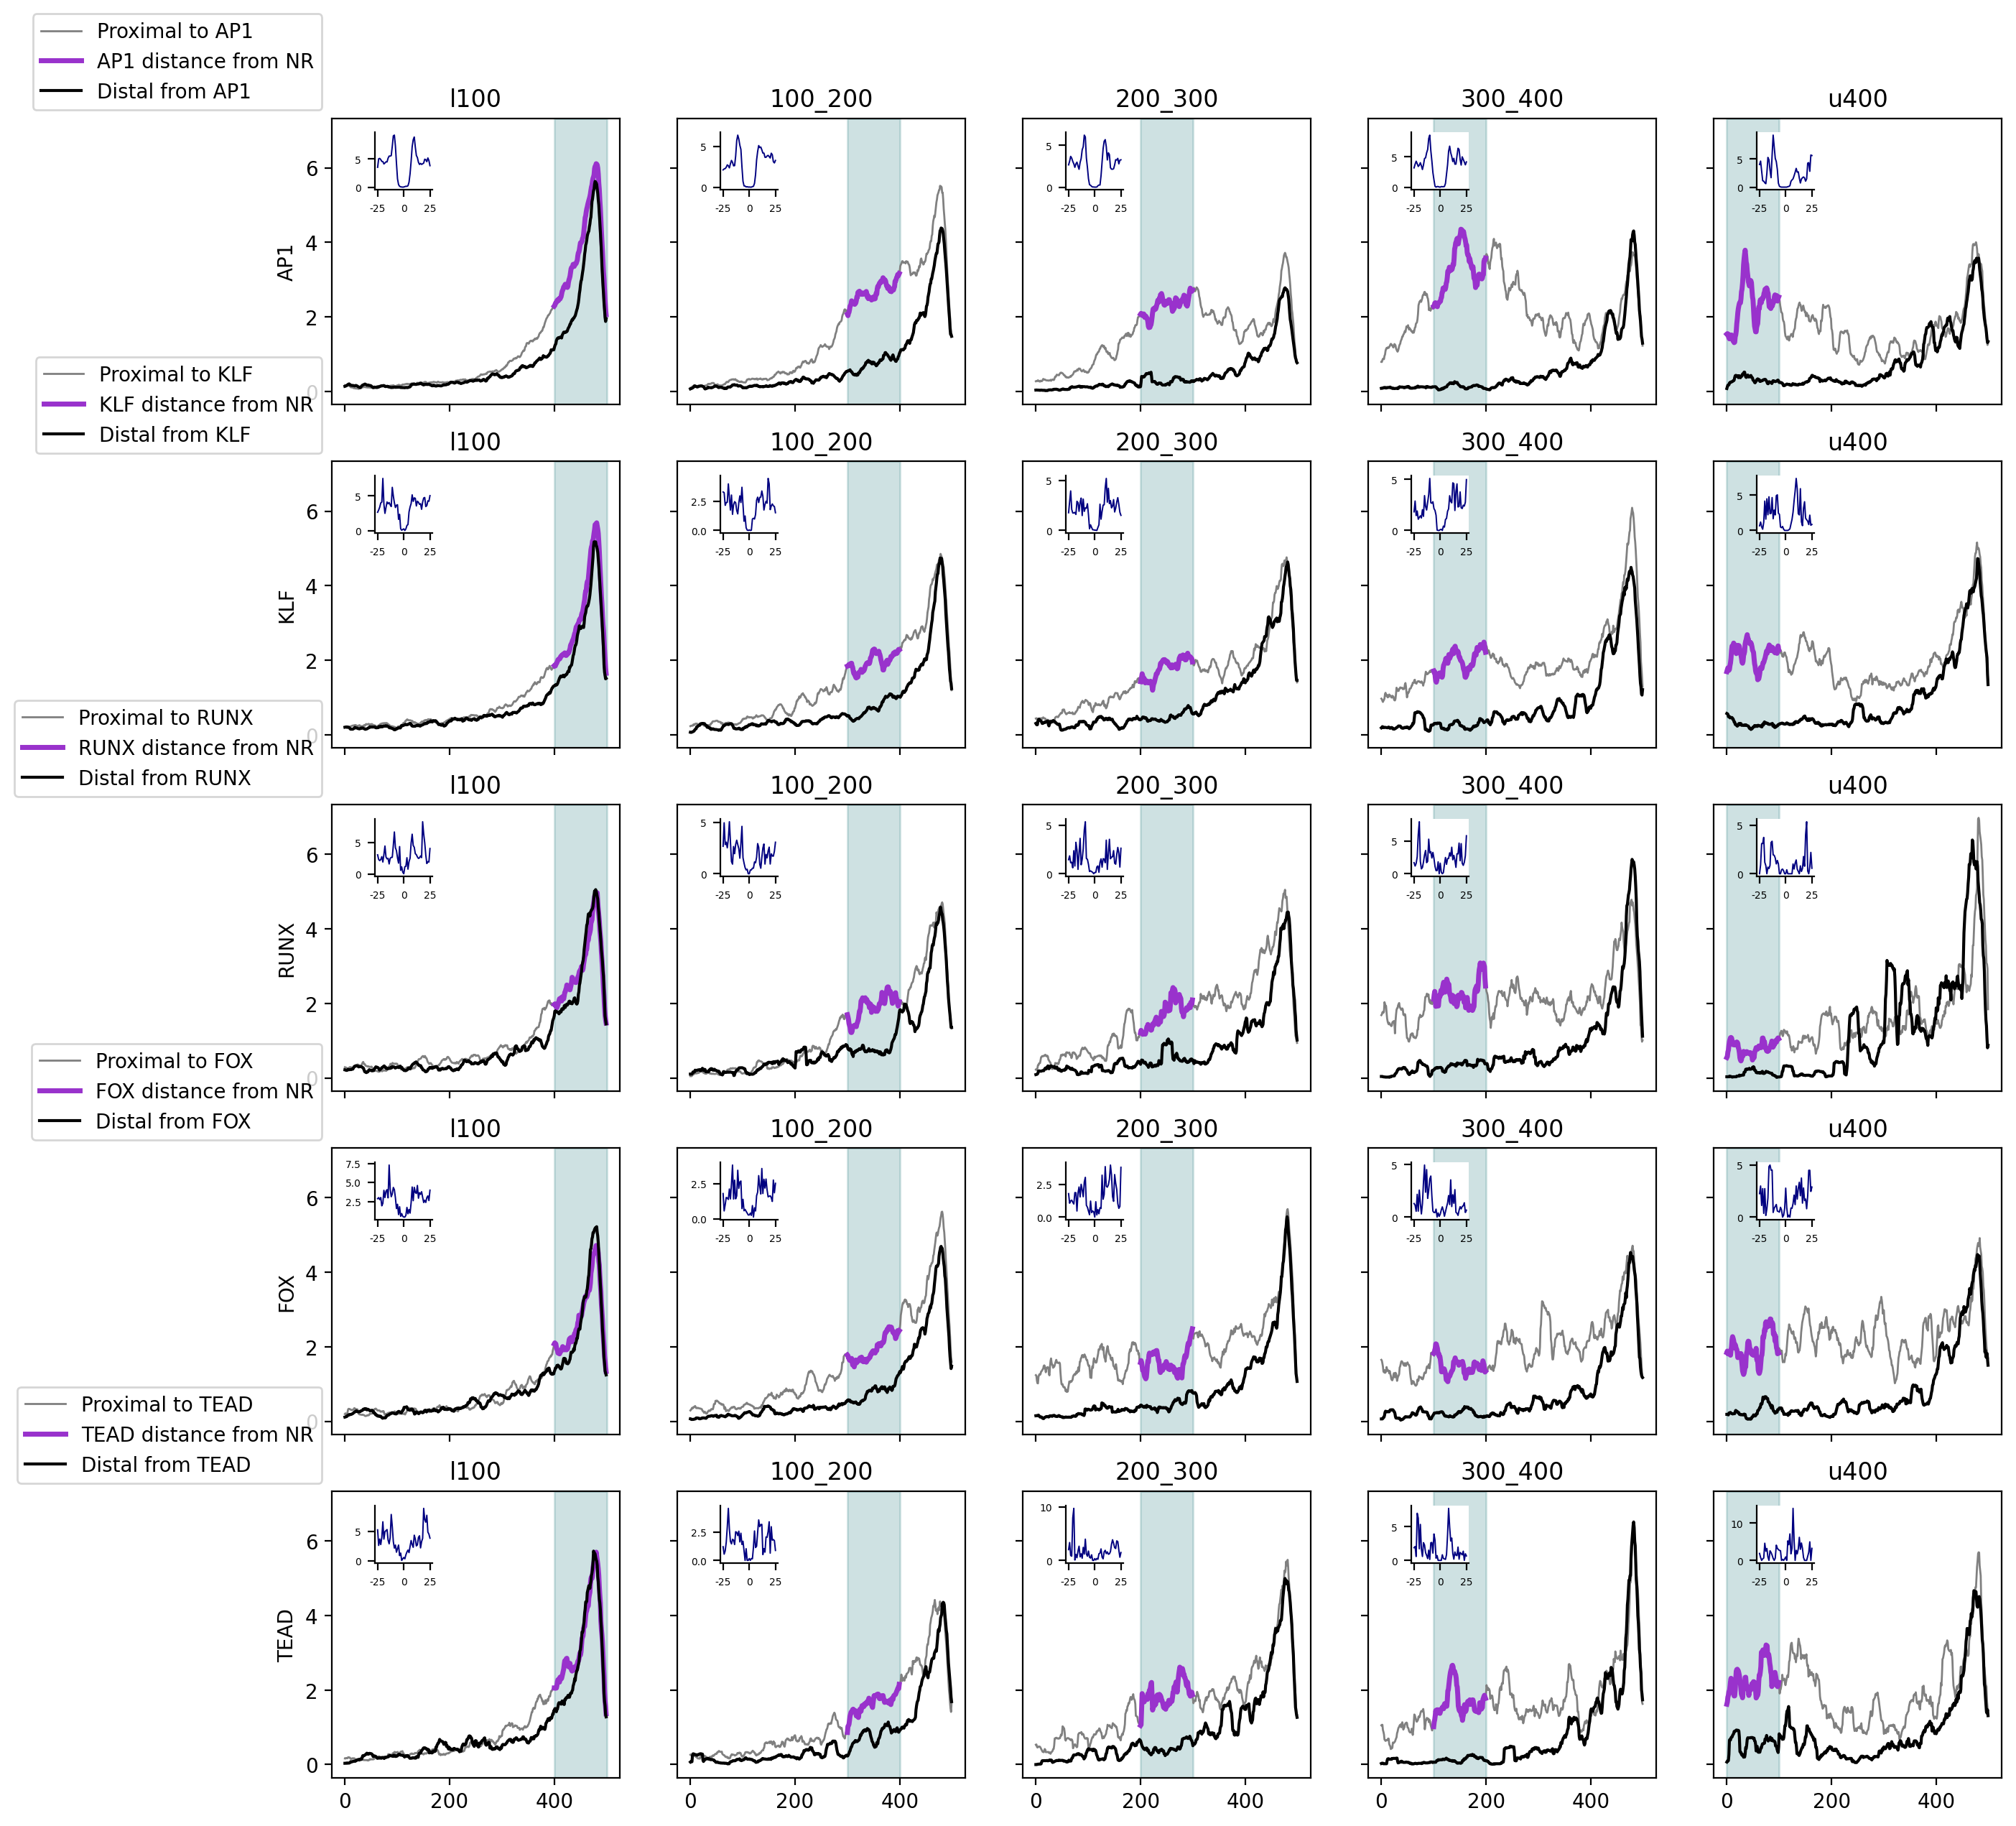

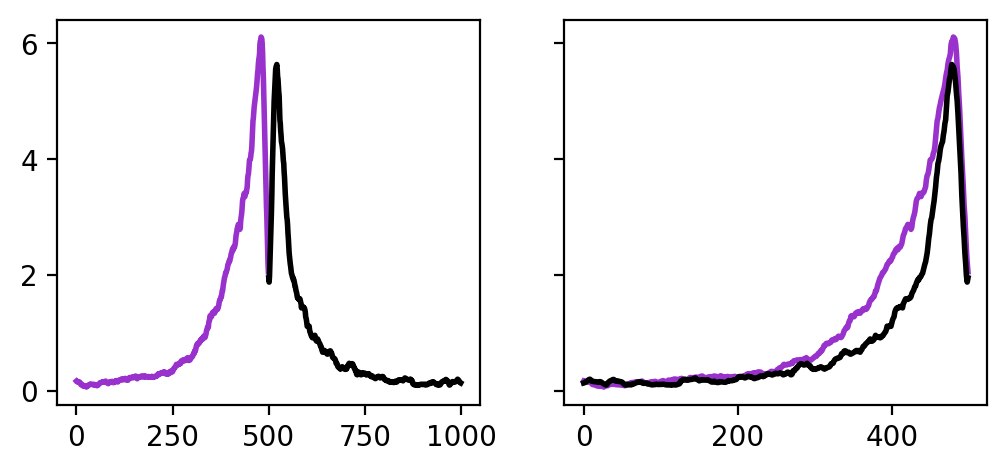

In [43]:
fig, ax = plt.subplots(5,5, sharey=True, sharex=True, figsize=(15,15))
rmse = defaultdict(dict)
for i,k in enumerate(['AP1', 'KLF', 'RUNX', 'FOX', 'TEAD']):
    
    axi = ax[i]
    axi[0].set_ylabel(k)
    for axii, key, lines, quer in zip(axi, ['l100', '100_200', '200_300', '300_400', 'u400'],
                                [(400,500), (300,400), (200,300), (100,200), (0, 100)],
                               ["absdist<=100","absdist>100 & absdist<=200","absdist>200 & absdist<=300",
                               "absdist>300 & absdist<=400","absdist>400 & absdist<475"]):
        
        smoothed = uniform_filter(means_dist[k][key], 20)
        proximal=smoothed[:500]
        distal = smoothed[500:][::-1]
        
        if  means_dist[k][key].sum() > 0:
            axii.plot(np.arange(500), proximal, label=f'Proximal to {k}', c='gray', lw=1, zorder=20)
            axii.plot(np.arange(lines[0], lines[1]), proximal[lines[0]:lines[1]], label=f'{k} distance from NR', c='darkorchid', lw=2.5, zorder=20)
            axii.plot(np.arange(500), distal,  label=f'Distal from {k}', c='k', lw=1.5, zorder=20)

            ins = axii.inset_axes([0.15,0.75,0.2,0.2])

            ins.plot(np.mean(fps[k].query(quer).apply(lambda x: x[475-x['absdist']:525-x['absdist']].values, axis=1), axis=0), c='navy', lw=.7)
            ins.set_xticklabels('')
            sns.despine(ax=ins, right=True, top=True)
            ins.set_xticks(np.arange(0,75, 25), np.arange(-25,50,25), size=5)
            ins.set_yticklabels(ins.get_yticklabels(), size=5)
            
            # rmse[k][f'{key}_rmse'] = np.mean(np.abs(proximal[lines[0]:lines[1]]- distal[lines[0]:lines[1]]))
            rmse[k][f'{key}_rmse'] = np.sqrt(np.mean((proximal[lines[0]:lines[1]]- distal[lines[0]:lines[1]])**2))

            # rmse[k][f'{key}_rmse'] = proximal[lines[0]:lines[1]].mean() / distal[lines[0]:lines[1]].mean()

            rmse[k][f'{key}_peak'] = distal[400:500].mean()
        if i==0 and axii == axi[0]:
            fig2, newax = plt.subplots(1,2, figsize=(6,2.5), sharey=True)
            newax[0].plot(np.arange(500), proximal, label=f'Proximal to {k}', c='darkorchid', lw=2, zorder=20)
            newax[0].plot(np.arange(500,1000), distal[::-1],  label=f'Distal from {k}', c='k', lw=2, zorder=20)
            newax[1].plot(np.arange(500), proximal, label=f'Proximal to {k}', c='darkorchid', lw=2, zorder=20)
            newax[1].plot(np.arange(500), distal,  label=f'Distal from {k}', c='k', lw=2, zorder=20)
            
            fig2.savefig('figures/Fig1/distal_proximal_example.pdf')

        axii.axvspan(lines[0], lines[1], alpha=0.3, color='cadetblue')
        axii.set_title(key)

    axi[0].legend(bbox_to_anchor=[0, 1.4])
fig.savefig('figures/Fig1/distal_proximal_all.pdf')

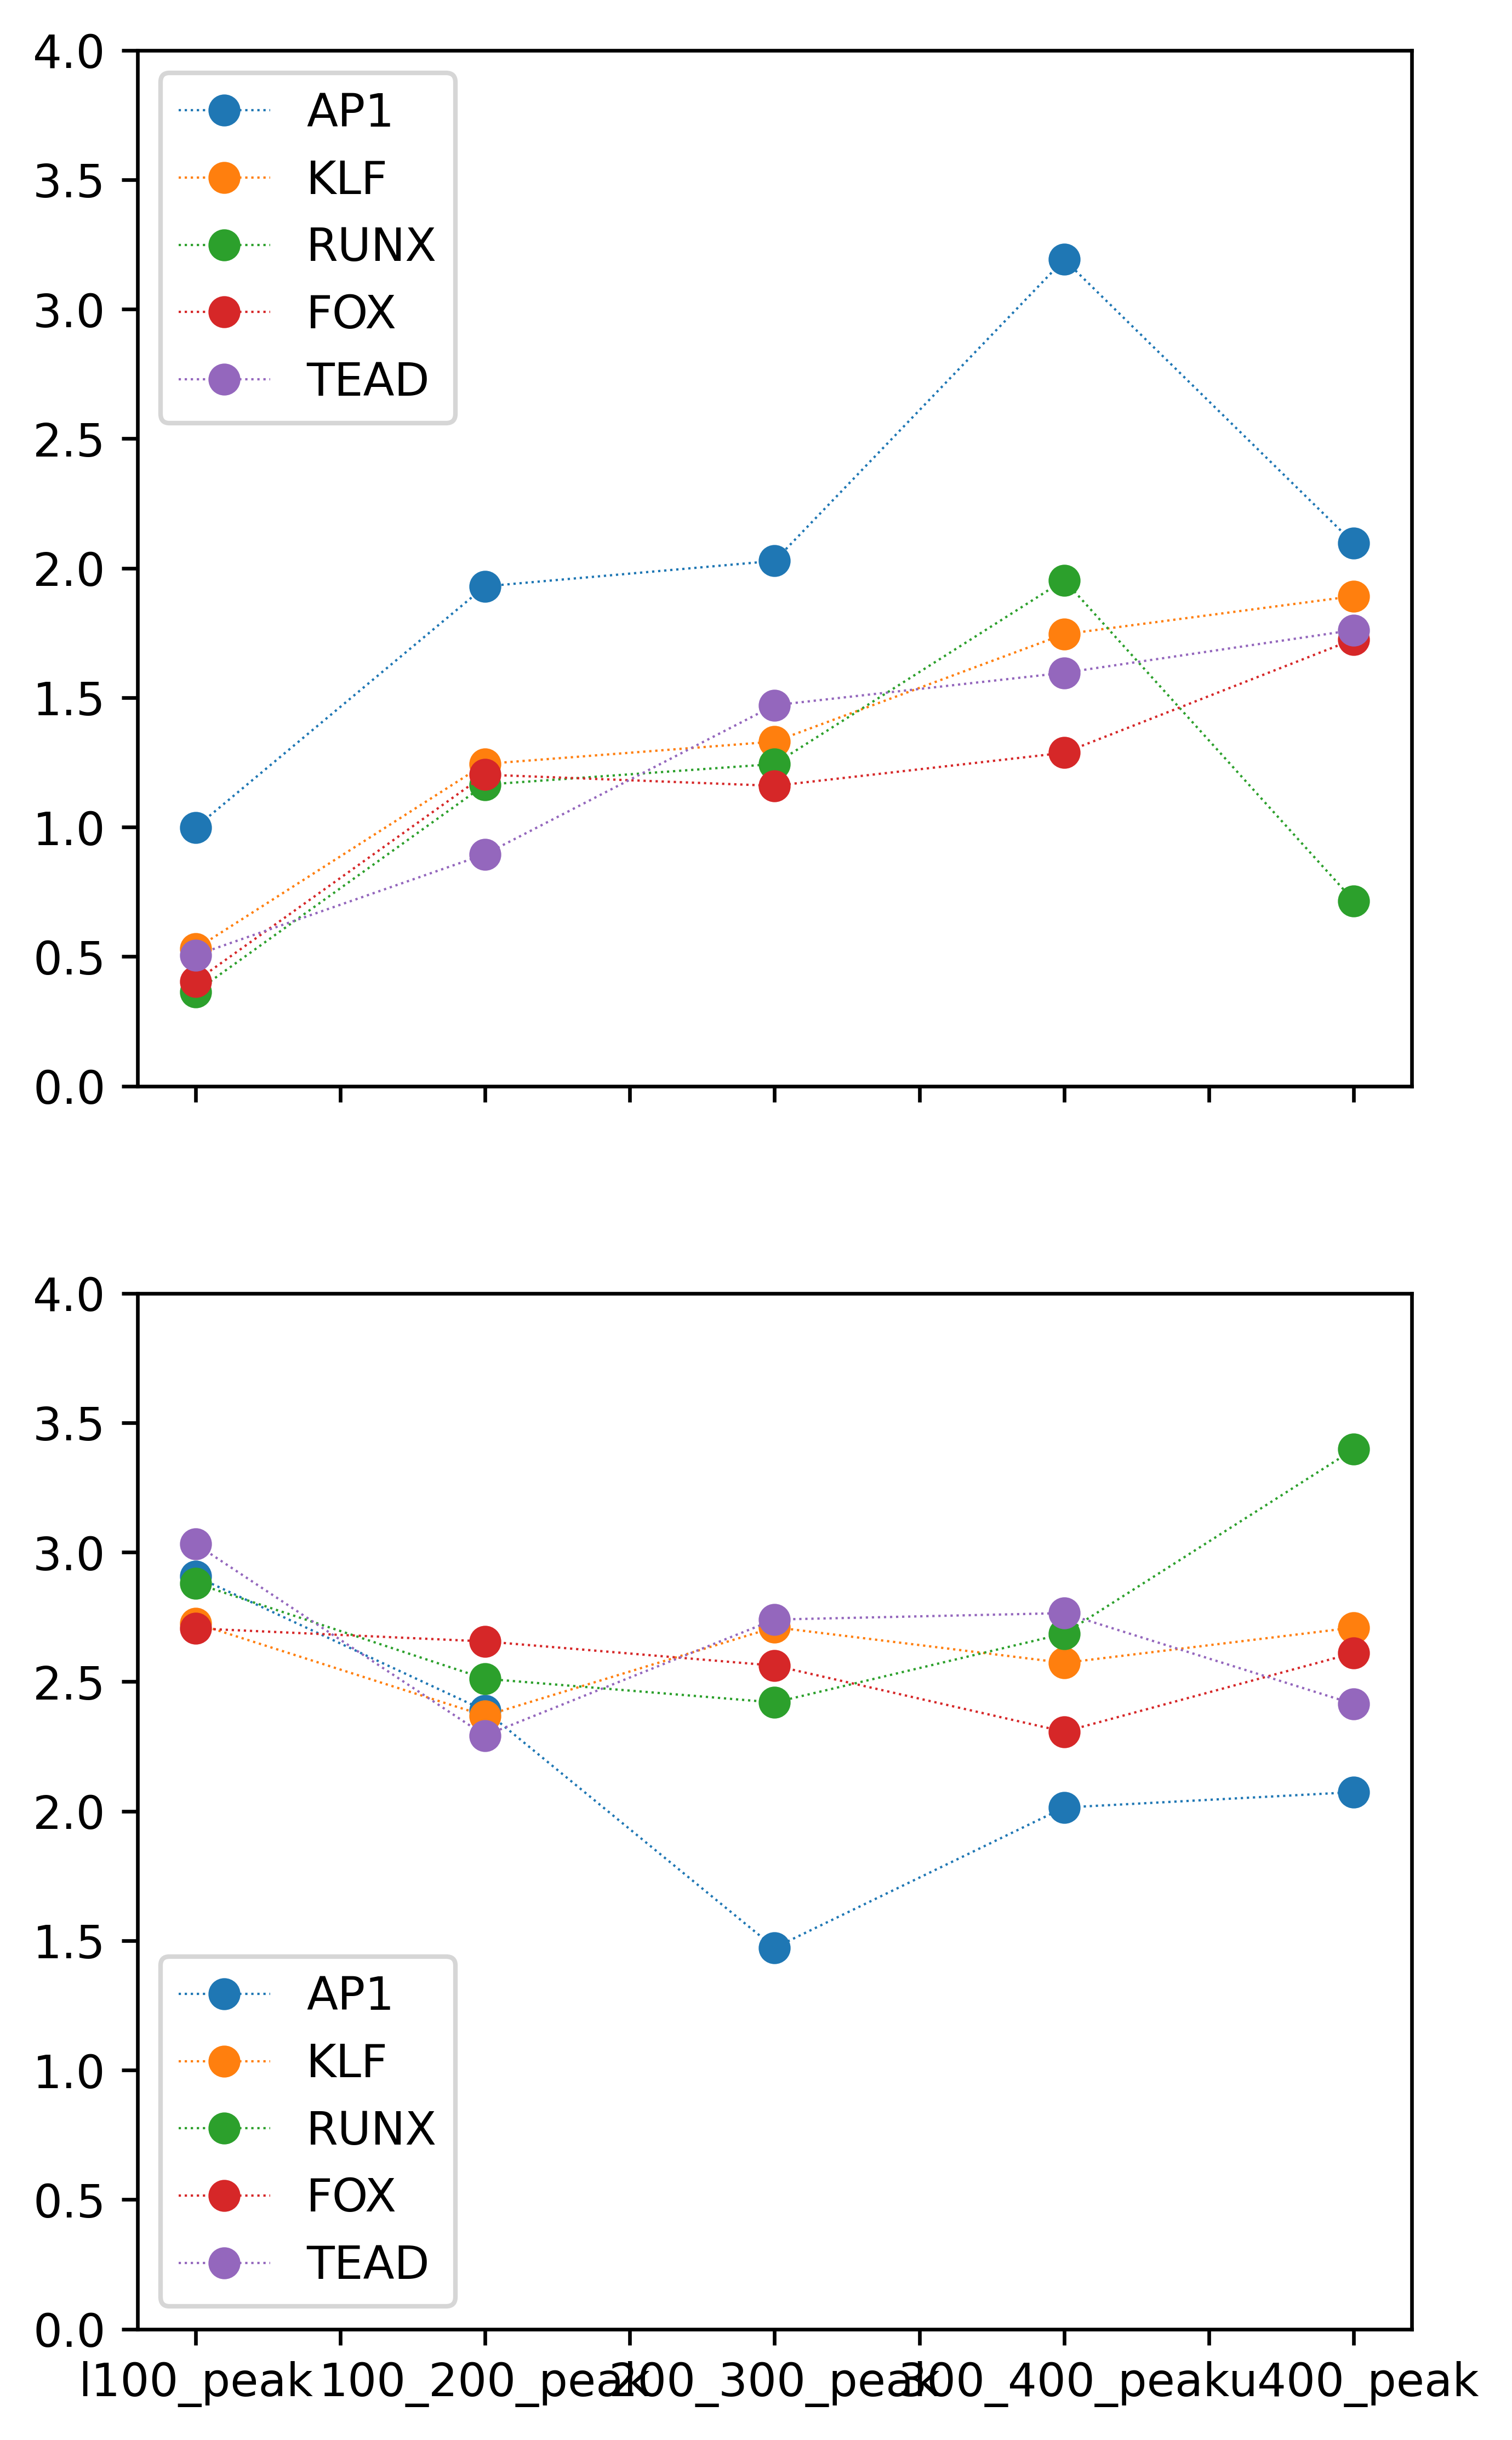

In [46]:
stats_df = pd.DataFrame(rmse)
fig, ax = plt.subplots(2,1, sharey=True, figsize=(5,9), sharex=True, dpi=300)
stats_df.filter(regex='rmse', axis=0).plot(ax=ax[0], marker='o', lw=0.5, ls=':', )
stats_df.filter(regex='peak', axis=0).plot(ax=ax[1], marker='o', lw=0.5, ls=':')
ax[0].set_ylim([0,4])

fig.savefig('figures/Fig1/interactions_summary.pdf')

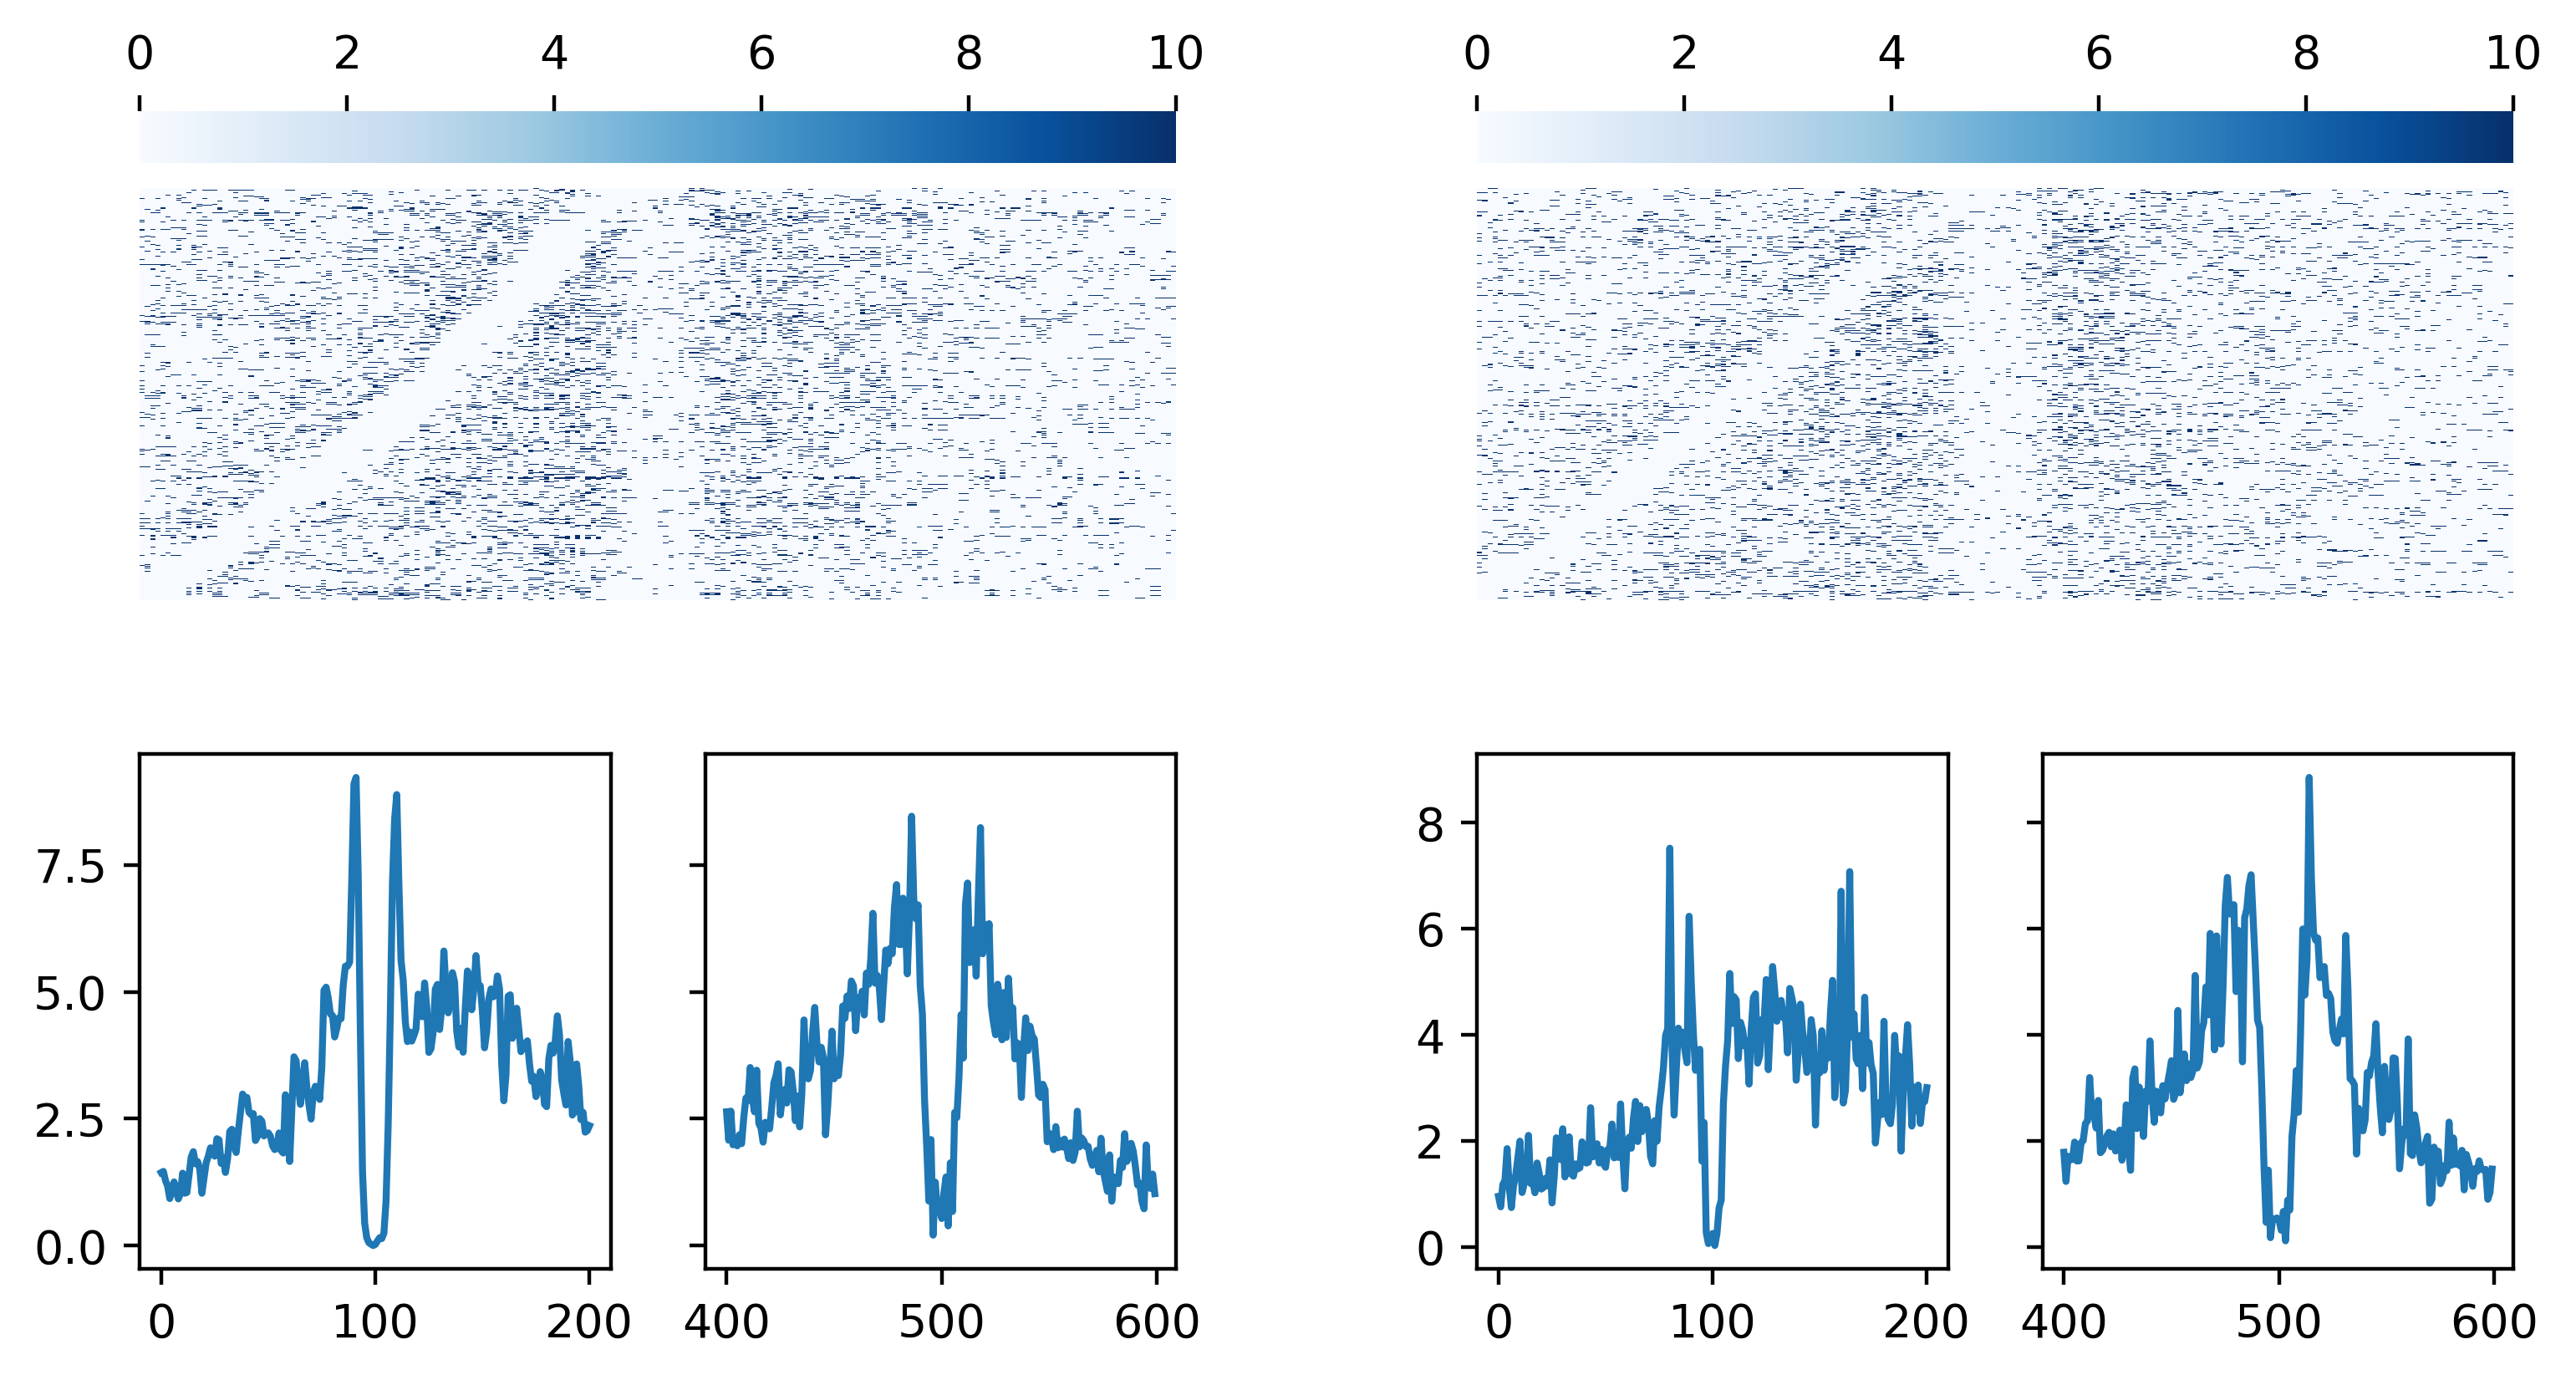

In [47]:
fig = plt.figure(dpi=200, figsize=(8,4))
subf = fig.subfigures(1, 2)

subsubf0 = subf[0].subfigures(2, 1)
ap1axhtmp = subsubf0[0].subplots(1)
ap1axmeans0,ap1axmeans1  = subsubf0[1].subplots(1,2, sharey=True)

sns.heatmap(fps['AP1'].query("absdist<=100").iloc[:, 400:600], vmax=10, cmap='Blues', ax=ap1axhtmp,
            xticklabels=False, yticklabels=False, rasterized=True, cbar_kws={'location':'top'})
ap1axmeans0.plot(np.mean(fps['AP1'].query("absdist<=100").apply(lambda x: x[400-x['absdist']:600-x['absdist']].values, axis=1), axis=0))

ap1axmeans1.plot(fps['AP1'].query("absdist<=100").iloc[:, 400:600].mean())

subsubf1 = subf[1].subfigures(2, 1)
klfaxhtmp = subsubf1[0].subplots(1)
klfaxmeans0,klfaxmeans1  = subsubf1[1].subplots(1,2, sharey=True)

sns.heatmap(fps['KLF'].query("absdist<=100").iloc[:, 400:600], vmax=10, cmap='Blues', ax=klfaxhtmp,
            xticklabels=False, yticklabels=False, rasterized=True, cbar_kws={'location':'top'})
klfaxmeans0.plot(np.mean(fps['KLF'].query("absdist<=100").apply(lambda x: x[400-x['absdist']:600-x['absdist']].values, axis=1), axis=0))

klfaxmeans1.plot(fps['KLF'].query("absdist<=100").iloc[:, 400:600].mean())

fig.savefig('figures/Fig1/interactors_htmp_example.pdf')